# End-to-End Clustering Pipeline
## Part 1: Data Collection & Preprocessing

This notebook implements a complete end-to-end machine learning pipeline for clustering analysis. We'll start with data collection and preprocessing, and then proceed through feature selection, feature engineering, model implementation, evaluation, and visualization.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

We begin by importing essential libraries for data manipulation, visualization, and analysis:

- **pandas**: For data manipulation and analysis
- **numpy**: For numerical operations
- **matplotlib and seaborn**: For data visualization
- **datetime**: For date/time operations

We configure display settings to ensure better readability of our outputs throughout the notebook.

In [ ]:
# 1. Data Collection
# Function to load data from various sources
def load_data(file_path, file_type='csv'):
    """
    Load data from various file types

    Parameters:
    file_path (str): Path to the data file
    file_type (str): Type of file (csv, excel, etc.)

    Returns:
    pandas.DataFrame: Loaded data
    """
    print(f"Loading data from {file_path}...")

    if file_type.lower() == 'csv':
        # Try different encodings if one fails
        encodings = ['utf-8', 'latin1', 'ISO-8859-1']
        for encoding in encodings:
            try:
                data = pd.read_csv(file_path, encoding=encoding)
                break
            except UnicodeDecodeError:
                continue
            except Exception as e:
                print(f"Error: {e}")
                return None
    elif file_type.lower() in ['excel', 'xlsx', 'xls']:
        try:
            data = pd.read_excel(file_path)
        except Exception as e:
            print(f"Error: {e}")
            return None
    else:
        raise ValueError("Unsupported file type. Please use CSV or Excel.")

    print(f"Data loaded successfully with {data.shape[0]} rows and {data.shape[1]} columns.")
    return data

# Change this path to your dataset location
file_path = '/content/UTSClustering.csv'
data = load_data(file_path)

### Data Loading Function

The `load_data()` function is designed to handle various file formats. It includes error handling for different encodings, which is crucial when working with diverse datasets.

**Key features:**
- Supports both CSV and Excel formats
- Attempts multiple encodings (utf-8, latin1, ISO-8859-1) for CSV files
- Provides informative error messages
- Returns a pandas DataFrame on successful loading

**Mathematical relevance:** While not mathematically intensive, this function establishes the foundation of our data matrix $X \in \mathbb{R}^{n \times p}$ where $n$ is the number of samples and $p$ is the number of features.

In [ ]:
# 2. Data Exploration
# Display basic information about the dataset
def explore_data(data):
    """Explore the dataset and provide basic information"""
    print("\n=== Basic Dataset Information ===")
    print(f"Dataset shape: {data.shape}")
    print("\nFirst 5 rows:")
    display(data.head())

    print("\nData types:")
    display(data.dtypes)

    print("\nBasic statistics:")
    display(data.describe(include='all').T)

    print("\nMissing values:")
    missing_values = data.isnull().sum()
    missing_percent = (data.isnull().sum() / len(data)) * 100
    missing_df = pd.DataFrame({'Missing Values': missing_values,
                              'Percentage (%)': missing_percent})
    display(missing_df[missing_df['Missing Values'] > 0])

    return missing_df

# Explore the dataset
missing_data = explore_data(data)

### Data Exploration

The `explore_data()` function performs an initial exploration of our dataset. This is critical for understanding the structure, quality, and characteristics of our data before proceeding to modeling.

**Key insights provided:**
- Overall dataset dimensions (rows × columns)
- Sample data to understand the content
- Data types of each column
- Statistical summary (mean, standard deviation, quartiles, etc.)
- Missing value analysis

**Mathematical relevance:**
- For numerical features, we examine the statistical moments:
  - Central tendency: $\mu = \frac{1}{n}\sum_{i=1}^{n}x_i$ (mean)
  - Dispersion: $\sigma = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(x_i - \mu)^2}$ (standard deviation)
  - Distribution: through percentiles (25%, 50%, 75%)
  
- For missing values, we calculate the percentage: $\text{Missing} (\%) = \frac{\sum \text{null values}}{n} \times 100$

Understanding these properties is crucial for detecting anomalies, outliers, and potential issues before modeling.

In [ ]:
# 3. Data Preprocessing
def preprocess_data(data):
    """Perform data preprocessing steps"""
    print("\n=== Data Preprocessing ===")
    # Create a copy to avoid modifying the original dataframe
    df = data.copy()

    # 3.1 Handle missing values
    print("\nHandling missing values...")
    # For retail transaction data like this, we'll handle missing values appropriately

    # For numerical columns: impute with median (more robust than mean against outliers)
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numerical_cols:
        if df[col].isnull().sum() > 0:
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)
            print(f"  - Filled missing values in '{col}' with median value {median_value:.4f}")

    # For categorical columns: impute with mode (most frequent)
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            mode_value = df[col].mode()[0]
            df[col].fillna(mode_value, inplace=True)
            print(f"  - Filled missing values in '{col}' with mode value '{mode_value}'")

    # 3.2 Convert data types
    print("\nConverting data types...")

    # Convert date columns if they exist
    date_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
    for col in date_cols:
        if col in df.columns and df[col].dtype == 'object':
            try:
                df[col] = pd.to_datetime(df[col])
                print(f"  - Converted '{col}' to datetime")
            except:
                print(f"  - Could not convert '{col}' to datetime")

    # 3.3 Handle duplicates
    print("\nChecking for duplicates...")
    duplicate_count = df.duplicated().sum()
    if duplicate_count > 0:
        print(f"  - Found {duplicate_count} duplicate rows")
        df.drop_duplicates(inplace=True)
        print(f"  - Removed duplicates. New shape: {df.shape}")
    else:
        print("  - No duplicates found")

    # 3.4 Check for outliers in numerical columns
    print("\nChecking for outliers...")
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        if not outliers.empty:
            outlier_percent = (len(outliers) / len(df)) * 100
            print(f"  - '{col}' has {len(outliers)} outliers ({outlier_percent:.2f}% of data)")
            print(f"    Range: [{df[col].min():.2f}, {df[col].max():.2f}], IQR boundaries: [{lower_bound:.2f}, {upper_bound:.2f}]")

    print("\nPreprocessing completed.")
    return df

# Preprocess the data
preprocessed_data = preprocess_data(data)

### Data Preprocessing

Data preprocessing is a crucial step in any machine learning pipeline. It ensures that the data is clean, consistent, and ready for analysis.

**1. Handling Missing Values**

We handle missing values differently based on the column type:
- For numerical columns: We use median imputation $\tilde{x} = \text{median}(x_1, x_2, ..., x_n)$
- For categorical columns: We use mode imputation $\hat{x} = \text{mode}(x_1, x_2, ..., x_n)$

These approaches are chosen to minimize the impact of outliers on our imputation strategy.

**2. Data Type Conversion**

Proper data types are essential for analysis:
- Date and time columns are converted to datetime objects
- This enables temporal analysis and feature extraction

**3. Duplicate Handling**

Duplicates can artificially bias our models, so we identify and remove them:
- We use the function $f(X) = \{x \in X \mid \nexists y \in X, y \neq x, \forall a \in A, y[a] = x[a]\}$
- Where $X$ is our dataset and $A$ is the set of all attributes

**4. Outlier Detection**

We use the Interquartile Range (IQR) method to detect outliers:
- $Q_1 = \text{25th percentile}$
- $Q_3 = \text{75th percentile}$
- $IQR = Q_3 - Q_1$
- Lower bound = $Q_1 - 1.5 \times IQR$
- Upper bound = $Q_3 + 1.5 \times IQR$
- Outliers are values $x$ where $x < \text{Lower bound}$ or $x > \text{Upper bound}$

This approach is robust and widely used for identifying values that fall far from the central distribution of the data.

In [ ]:
# 4. Additional Data Preparation - Feature Creation for Retail Data
def prepare_retail_features(df):
    """Create retail-specific features from transactional data"""
    print("\n=== Creating Retail-Specific Features ===")
    retail_df = df.copy()

    # 1. Calculate total price per item
    if 'Quantity' in retail_df.columns and 'UnitPrice' in retail_df.columns:
        retail_df['TotalPrice'] = retail_df['Quantity'] * retail_df['UnitPrice']
        print("  - Created 'TotalPrice' feature (Quantity * UnitPrice)")

    # 2. Extract datetime components if available
    date_cols = [col for col in retail_df.columns if 'date' in col.lower() or 'time' in col.lower()]
    for date_col in date_cols:
        if retail_df[date_col].dtype.name == 'datetime64[ns]':
            # Extract components
            retail_df[f'{date_col}_Year'] = retail_df[date_col].dt.year
            retail_df[f'{date_col}_Month'] = retail_df[date_col].dt.month
            retail_df[f'{date_col}_Day'] = retail_df[date_col].dt.day
            retail_df[f'{date_col}_DayOfWeek'] = retail_df[date_col].dt.dayofweek
            retail_df[f'{date_col}_Hour'] = retail_df[date_col].dt.hour
            print(f"  - Extracted year, month, day, day of week, and hour from '{date_col}'")
        elif 'object' in str(retail_df[date_col].dtype):
            # Try to convert to datetime first
            try:
                retail_df[date_col] = pd.to_datetime(retail_df[date_col])
                # Now extract components
                retail_df[f'{date_col}_Year'] = retail_df[date_col].dt.year
                retail_df[f'{date_col}_Month'] = retail_df[date_col].dt.month
                retail_df[f'{date_col}_Day'] = retail_df[date_col].dt.day
                retail_df[f'{date_col}_DayOfWeek'] = retail_df[date_col].dt.dayofweek
                retail_df[f'{date_col}_Hour'] = retail_df[date_col].dt.hour
                print(f"  - Converted and extracted year, month, day, day of week, and hour from '{date_col}'")
            except:
                print(f"  - Could not extract date components from '{date_col}'")

    # 3. Aggregate features by customer (if CustomerID exists)
    if 'CustomerID' in retail_df.columns:
        # Calculate per-customer metrics
        if 'TotalPrice' in retail_df.columns:
            # Total spending per customer
            customer_spending = retail_df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
            customer_spending.columns = ['CustomerID', 'TotalSpending']

            # Average order value per customer
            if 'InvoiceNo' in retail_df.columns:
                avg_order = retail_df.groupby(['CustomerID', 'InvoiceNo'])['TotalPrice'].sum().reset_index()
                avg_order = avg_order.groupby('CustomerID')['TotalPrice'].mean().reset_index()
                avg_order.columns = ['CustomerID', 'AvgOrderValue']

                # Merge these metrics back to the original dataframe
                retail_df = pd.merge(retail_df, customer_spending, on='CustomerID', how='left')
                retail_df = pd.merge(retail_df, avg_order, on='CustomerID', how='left')

                print("  - Created customer-level features: TotalSpending, AvgOrderValue")

    # 4. Create product category features (if applicable)
    if 'Description' in retail_df.columns:
        # Simple category extraction based on first word
        retail_df['ProductCategory'] = retail_df['Description'].str.split().str[0]
        print("  - Created 'ProductCategory' feature from Description")

    # 5. Count total unique items per invoice
    if 'InvoiceNo' in retail_df.columns and 'StockCode' in retail_df.columns:
        item_counts = retail_df.groupby('InvoiceNo')['StockCode'].nunique().reset_index()
        item_counts.columns = ['InvoiceNo', 'UniqueItemCount']
        retail_df = pd.merge(retail_df, item_counts, on='InvoiceNo', how='left')
        print("  - Created 'UniqueItemCount' feature (number of unique items in invoice)")

    print(f"Final dataframe shape after feature creation: {retail_df.shape}")
    return retail_df

# Prepare retail-specific features
retail_df = prepare_retail_features(preprocessed_data)

### Retail-Specific Feature Creation

For retail transaction data, we create domain-specific features that will enhance our clustering models. These features represent customer behavior patterns and transaction characteristics.

**1. Total Price Calculation**

We calculate the total price per line item using:
$$\text{TotalPrice} = \text{Quantity} \times \text{UnitPrice}$$

This represents the actual monetary value of each transaction line.

**2. Temporal Feature Extraction**

From datetime columns, we extract multiple components:
- Year: $\text{year}(d) \in \{2000, 2001, ..., 2025\}$
- Month: $\text{month}(d) \in \{1, 2, ..., 12\}$
- Day: $\text{day}(d) \in \{1, 2, ..., 31\}$
- Day of Week: $\text{weekday}(d) \in \{0, 1, ..., 6\}$ where 0 = Monday
- Hour: $\text{hour}(d) \in \{0, 1, ..., 23\}$

These temporal features allow our models to capture cyclical patterns in purchasing behavior.

**3. Customer-Level Aggregations**

For each customer, we calculate:
- Total Spending: $\text{TotalSpending}_c = \sum_{i \in T_c} \text{TotalPrice}_i$
  where $T_c$ is the set of all transactions by customer $c$
  
- Average Order Value: $\text{AvgOrderValue}_c = \frac{\sum_{o \in O_c} \sum_{i \in I_o} \text{TotalPrice}_i}{|O_c|}$
  where $O_c$ is the set of all orders by customer $c$ and $I_o$ is the set of all items in order $o$

These metrics capture the overall spending behavior and average transaction value for each customer.

**4. Product Categorization**

We extract simple product categories from descriptions:
$$\text{ProductCategory} = \text{firstWord}(\text{Description})$$

This provides a basic categorization of products.

**5. Invoice Complexity**

We calculate the unique item count per invoice:
$$\text{UniqueItemCount}_i = |\{\text{StockCode}_j : j \in \text{Invoice}_i\}|$$

This feature represents the diversity of items in each transaction, which can be an indicator of customer purchasing behavior.

In [ ]:
# 5. Feature Selection - Initial Analysis
def analyze_features(df):
    """Analyze features to understand their importance for clustering"""
    print("\n=== Feature Analysis ===")

    # 1. Check cardinality of categorical features
    print("\nCardinality of categorical features:")
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        cardinality = df[col].nunique()
        print(f"  - '{col}': {cardinality} unique values")
        if cardinality < 10:  # Show distribution for low-cardinality features
            print(df[col].value_counts().nlargest(10))

    # 2. Check distribution of numerical features
    print("\nDistribution of numerical features:")
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numerical_cols:
        print(f"\n  - '{col}' statistics:")
        print(df[col].describe())

        # Plot histogram
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot of {col}")
        plt.tight_layout()
        plt.show()

    # 3. Correlation analysis for numerical features
    if len(numerical_cols) > 1:
        print("\nCorrelation matrix for numerical features:")
        correlation_matrix = df[numerical_cols].corr()
        display(correlation_matrix)

        # Plot correlation heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Correlation Matrix of Numerical Features')
        plt.tight_layout()
        plt.show()

    return categorical_cols, numerical_cols

# Analyze features
categorical_cols, numerical_cols = analyze_features(retail_df)

### Feature Analysis

Before proceeding to formal feature selection, we analyze the features to understand their characteristics, distributions, and potential value for clustering.

**1. Categorical Feature Analysis**

For categorical features, we examine their cardinality (number of unique values):
$$\text{Cardinality}(X) = |\{x_i : x_i \in X\}|$$

This helps us identify:
- Low-cardinality features that might be directly usable in clustering
- High-cardinality features that might require encoding or dimension reduction
- Features with very high cardinality that might be identifiers rather than meaningful categories

**2. Numerical Feature Distribution Analysis**

For numerical features, we examine their statistical properties and distributions:
- Central tendency: mean, median
- Dispersion: standard deviation, IQR
- Range: min, max
- Distribution shape: through histograms (skewness, modality)
- Outliers: through boxplots

The skewness of a distribution is mathematically defined as:
$$\text{Skewness} = \frac{E[(X-\mu)^3]}{\sigma^3}$$

Where:
- $\mu$ is the mean
- $\sigma$ is the standard deviation
- $E$ is the expectation operator

**3. Correlation Analysis**

We calculate the Pearson correlation coefficient between pairs of numerical features:
$$\rho_{X,Y} = \frac{\text{cov}(X,Y)}{\sigma_X \sigma_Y} = \frac{E[(X-\mu_X)(Y-\mu_Y)]}{\sigma_X \sigma_Y}$$

Where:
- $\text{cov}(X,Y)$ is the covariance between features $X$ and $Y$
- $\sigma_X$ and $\sigma_Y$ are the standard deviations of $X$ and $Y$
- $\mu_X$ and $\mu_Y$ are the means of $X$ and $Y$

The correlation matrix helps us identify:
- Highly correlated features that might be redundant
- Feature groups that capture similar information
- Independent features that provide unique information

This analysis guides our feature selection process, helping us identify which features to keep, transform, or discard in our clustering models.

# End-to-End Clustering Pipeline
## Part 2: Feature Selection

In this part, we implement comprehensive feature selection techniques to identify the most relevant features for our clustering models. We'll implement multiple methods including:
1. Removal of Constant and Quasi-Constant Features
2. Removal of Duplicate Features
3. Correlation-based Feature Selection
4. Mutual Information Analysis
5. Chi-Square Test for Categorical Features
6. ANOVA and MANOVA for Numerical Features

In [ ]:
# Import additional libraries for feature selection
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_regression, chi2, f_classif
from scipy import stats
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform

We're importing additional libraries for our feature selection process:

- **scikit-learn feature selection modules**: For implementing various feature selection techniques
- **scipy.stats**: For statistical tests
- **statsmodels**: For more advanced statistical methods like MANOVA
- **sklearn preprocessing**: For data transformation needed for some feature selection methods
- **sklearn pipeline components**: For building feature selection pipelines
- **scipy clustering and distance modules**: For hierarchical feature clustering

In [ ]:
# 1. Removing Constant and Quasi-Constant Features
def remove_constant_features(df, threshold=0.01):
    """Remove features with low variance (constant or quasi-constant)"""
    print("\n=== Removing Constant and Quasi-Constant Features ===")
    print(f"Variance threshold: {threshold}")

    # Separate numerical and categorical columns for processing
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    date_cols = df.select_dtypes(include=['datetime64']).columns.tolist()

    # Process numerical columns
    constant_num_features = []
    if numerical_cols:
        # Normalize numerical features before checking variance
        scaler = MinMaxScaler()
        numerical_data = scaler.fit_transform(df[numerical_cols])
        numerical_data = pd.DataFrame(numerical_data, columns=numerical_cols)

        # Check variance
        for col in numerical_cols:
            variance = numerical_data[col].var()
            if variance < threshold:
                constant_num_features.append(col)
                print(f"  - Removing numerical feature '{col}' with variance {variance:.6f} (below threshold)")

    # Process categorical columns
    constant_cat_features = []
    if categorical_cols:
        for col in categorical_cols:
            # Calculate ratio of most frequent category
            dominant_freq = df[col].value_counts(normalize=True).max()
            if dominant_freq > (1 - threshold):
                constant_cat_features.append(col)
                print(f"  - Removing categorical feature '{col}' with dominant frequency {dominant_freq:.4f} (above 1-threshold)")

    # Combine and drop constant features
    constant_features = constant_num_features + constant_cat_features
    if constant_features:
        print(f"Removing {len(constant_features)} constant/quasi-constant features")
        df_filtered = df.drop(columns=constant_features)
        print(f"Original shape: {df.shape}, New shape: {df_filtered.shape}")
    else:
        print("No constant/quasi-constant features found")
        df_filtered = df.copy()

    return df_filtered, constant_features

# Remove constant and quasi-constant features
df_no_constant, constant_features = remove_constant_features(retail_df)

### 1. Constant & Quasi-Constant Feature Removal

This function removes features with low variance, as these features provide little discriminative information for clustering.

**Mathematical Foundation:**

For numerical features, we calculate the variance after normalization:

1. Normalization: Scale each numerical feature to [0,1] range
   $$X'_i = \frac{X_i - \min(X)}{\max(X) - \min(X)}$$

2. Variance calculation:
   $$\text{Var}(X') = \frac{1}{n} \sum_{i=1}^{n} (X'_i - \mu_{X'})^2$$

   Where $\mu_{X'}$ is the mean of the normalized feature.

3. Threshold comparison:
   If $\text{Var}(X') < \text{threshold}$, the feature is considered quasi-constant and removed.

For categorical features, we use a different approach:

1. Calculate the frequency of the most common category:
   $$f_{\max} = \max_{c \in C} \frac{|\{i : X_i = c\}|}{n}$$

   Where $C$ is the set of all categories for feature $X$.

2. Threshold comparison:
   If $f_{\max} > (1 - \text{threshold})$, the feature is considered quasi-constant and removed.

**Importance for Clustering:**

Constant or quasi-constant features create a "flat" dimension in the feature space where most data points have the same or similar values. This adds noise to distance calculations without providing useful information for separating clusters. Removing these features improves computational efficiency and can lead to more meaningful clusters.

In [ ]:
# 2. Removing Duplicate Features
def remove_duplicate_features(df):
    """Identify and remove duplicate features"""
    print("\n=== Removing Duplicate Features ===")

    # Separate numerical and categorical columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    date_cols = df.select_dtypes(include=['datetime64']).columns.tolist()

    duplicate_features = []

    # Check for duplicates among numerical features
    if len(numerical_cols) > 1:
        # Compute correlation matrix
        correlation = df[numerical_cols].corr().abs()

        # Create mask for upper triangle to avoid duplicate checks
        upper_tri = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))

        # Find features with perfect correlation (duplicate)
        for col in upper_tri.columns:
            # Get perfect correlations (allowing for small float precision errors)
            perfect_corr = upper_tri[col][upper_tri[col] > 0.9999]

            if not perfect_corr.empty:
                for idx, value in perfect_corr.items():
                    print(f"  - Features '{col}' and '{idx}' are perfectly correlated (r={value:.6f})")
                    # Add the second column to duplicates (keep the first one)
                    if idx not in duplicate_features:
                        duplicate_features.append(idx)

    # Check for duplicates among categorical features
    # This is more complex as we can't use correlation
    if len(categorical_cols) > 1:
        for i, col1 in enumerate(categorical_cols):
            for col2 in categorical_cols[i+1:]:
                # Check if the features have the same unique values count
                if df[col1].nunique() == df[col2].nunique():
                    # Check if they always have the same values for each row
                    # Here we create a temporary measure by combining the columns
                    combined1 = df[col1].astype(str) + '_' + df[col2].astype(str)
                    if combined1.nunique() == df[col1].nunique():
                        print(f"  - Categorical features '{col1}' and '{col2}' appear to be duplicates")
                        # Add the second column to duplicates (keep the first one)
                        if col2 not in duplicate_features:
                            duplicate_features.append(col2)

    # Drop duplicate features
    if duplicate_features:
        print(f"Removing {len(duplicate_features)} duplicate features: {duplicate_features}")
        df_filtered = df.drop(columns=duplicate_features)
        print(f"Original shape: {df.shape}, New shape: {df_filtered.shape}")
    else:
        print("No duplicate features found")
        df_filtered = df.copy()

    return df_filtered, duplicate_features

# Remove duplicate features
df_no_duplicates, duplicate_features = remove_duplicate_features(df_no_constant)

### 2. Duplicate Feature Removal

This function identifies and removes features that provide identical or nearly identical information.

**Mathematical Foundation:**

For numerical features, we identify duplicates using Pearson correlation:

1. Calculate the absolute correlation matrix:
   $$r_{X,Y} = \left|\frac{\text{cov}(X,Y)}{\sigma_X \sigma_Y}\right| = \left|\frac{E[(X-\mu_X)(Y-\mu_Y)]}{\sigma_X \sigma_Y}\right|$$

2. Identify perfect correlations (allowing for small floating-point precision errors):
   Features $X$ and $Y$ are considered duplicates if $r_{X,Y} > 0.9999$

For categorical features, we use a different approach:

1. Check if two categorical features have the same number of unique values:
   $$|\{x : x \in X\}| = |\{y : y \in Y\}|$$

2. Create a combined feature by concatenating the values:
   $$Z_i = X_i + "_" + Y_i$$

3. Check if the combined feature has the same number of unique values as each original feature:
   $$|\{z : z \in Z\}| = |\{x : x \in X\}|$$

   If this condition is true, the features provide the same information and one can be removed.

**Importance for Clustering:**

Duplicate features artificially increase the weight of certain information in distance calculations. For example, if the same feature is included twice, distances along that dimension are effectively counted double. This can bias clustering algorithms toward patterns in the duplicated dimensions. Removing duplicates ensures each information aspect is given appropriate weight in the clustering algorithm.

In [ ]:
# 3. Correlation-Based Feature Selection
def correlation_feature_selection(df, threshold=0.85):
    """Select features based on correlation threshold"""
    print(f"\n=== Correlation-Based Feature Selection (threshold: {threshold}) ===")

    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    if len(numerical_cols) <= 1:
        print("Too few numerical features for correlation analysis")
        return df.copy(), []

    # Compute correlation matrix
    correlation = df[numerical_cols].corr().abs()

    # Visualize correlation matrix
    plt.figure(figsize=(14, 12))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()

    # Create upper triangle mask (to avoid duplicate checks)
    upper_tri = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))

    # Find features with correlation greater than threshold
    to_drop = []
    for col in upper_tri.columns:
        # Get highly correlated features
        high_corr = upper_tri[col][upper_tri[col] > threshold]

        if not high_corr.empty:
            for idx, value in high_corr.items():
                print(f"  - Features '{col}' and '{idx}' are highly correlated (r={value:.4f})")

                # Choose which feature to drop based on correlation with other features
                if idx not in to_drop and col not in to_drop:
                    # Calculate the mean correlation with other features
                    mean_corr_idx = correlation[idx].mean()
                    mean_corr_col = correlation[col].mean()

                    print(f"    Mean correlation: '{col}': {mean_corr_col:.4f}, '{idx}': {mean_corr_idx:.4f}")

                    # Drop the feature with higher mean correlation (more redundant)
                    if mean_corr_idx > mean_corr_col:
                        if idx not in to_drop:
                            to_drop.append(idx)
                            print(f"    Selecting '{idx}' for removal (higher mean correlation)")
                    else:
                        if col not in to_drop:
                            to_drop.append(col)
                            print(f"    Selecting '{col}' for removal (higher mean correlation)")

    # Drop correlated features
    if to_drop:
        print(f"\nRemoving {len(to_drop)} highly correlated features: {to_drop}")
        df_filtered = df.drop(columns=to_drop)
        print(f"Original shape: {df.shape}, New shape: {df_filtered.shape}")
    else:
        print("No highly correlated features found above threshold")
        df_filtered = df.copy()

    return df_filtered, to_drop

# Apply correlation-based feature selection
df_corr_filtered, correlated_features = correlation_feature_selection(df_no_duplicates, threshold=0.85)

### 3. Correlation-Based Feature Selection

This function identifies and removes highly correlated features to reduce redundancy while preserving information diversity.

**Mathematical Foundation:**

1. Calculate the absolute correlation matrix for all numerical features:
   $$r_{X,Y} = \left|\frac{\text{cov}(X,Y)}{\sigma_X \sigma_Y}\right|$$

2. For each pair of features with correlation above the threshold ($r_{X,Y} > \text{threshold}$), determine which one to remove based on their average correlation with all other features.

3. For each feature, calculate the mean absolute correlation with all other features:
   $$\bar{r}_X = \frac{1}{p-1} \sum_{Y \neq X} |r_{X,Y}|$$

   Where $p$ is the total number of features.

4. Between two highly correlated features $X$ and $Y$, remove the one with the higher mean correlation, as it contains more redundant information:
   If $\bar{r}_X > \bar{r}_Y$, remove $X$; otherwise, remove $Y$.

**Strategic Approach:**

This strategy is more sophisticated than simple pairwise elimination. By considering each feature's correlation with all other features, we prioritize keeping features that provide unique information. Features with higher average correlation are more redundant with the overall feature set, so removing them minimizes information loss.

**Importance for Clustering:**

Highly correlated features represent the same underlying phenomenon from different angles. Including multiple highly correlated features can:
1. Bias clustering algorithms toward the information captured by these correlated dimensions
2. Add computational overhead without adding proportional information value
3. Create dimensionality issues that complicate distance calculations

By keeping only one feature from each group of correlated features, we maintain the information diversity while reducing dimensionality, leading to more balanced and often more interpretable clustering results.

In [ ]:
# 4. Mutual Information Analysis
def mutual_information_selection(df, k='all'):
    """Select features based on mutual information"""
    print("\n=== Mutual Information Feature Selection ===")

    # Separate numerical and categorical features
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    if len(numerical_cols) < 2:
        print("Not enough numerical features for MI analysis")
        return df.copy(), {}

    # For clustering, we don't have a target variable
    # We'll calculate MI between each feature and all other features
    feature_mi_scores = {}

    # For each numerical feature, calculate MI with all other features
    for col in numerical_cols:
        # Create a normalized version of the current feature to use as target
        target = df[col].values.reshape(-1, 1)
        target_normalized = StandardScaler().fit_transform(target).ravel()

        # Get all other numerical features
        other_features = [c for c in numerical_cols if c != col]

        if not other_features:
            continue

        # Calculate MI for each feature against the target
        X = df[other_features]
        mi_scores = mutual_info_regression(X, target_normalized)

        # Store the scores
        for feature, score in zip(other_features, mi_scores):
            feature_pair = tuple(sorted([col, feature]))
            if feature_pair not in feature_mi_scores:
                feature_mi_scores[feature_pair] = score

    # Rank MI scores
    ranked_mi_pairs = sorted(feature_mi_scores.items(), key=lambda x: x[1], reverse=True)

    # Print top MI scores
    print("Top Mutual Information Scores:")
    for pair, score in ranked_mi_pairs[:10]:
        print(f"  - Features {pair}: MI = {score:.4f}")

    # Calculate average MI score for each feature
    feature_avg_mi = {}
    for feat in numerical_cols:
        # Find all pairs containing this feature
        pairs_with_feat = [pair for pair in feature_mi_scores.keys() if feat in pair]
        if pairs_with_feat:
            avg_mi = sum(feature_mi_scores[pair] for pair in pairs_with_feat) / len(pairs_with_feat)
            feature_avg_mi[feat] = avg_mi

    # Rank features by average MI
    ranked_features = sorted(feature_avg_mi.items(), key=lambda x: x[1], reverse=True)

    print("\nAverage Mutual Information per Feature:")
    for feature, avg_mi in ranked_features:
        print(f"  - {feature}: {avg_mi:.4f}")

    # For clustering, we don't remove features based on MI
    # Instead, we provide the MI scores for information
    print("\nFor clustering, all features are retained, MI scores are provided for reference")

    # Calculate feature importances based on normalized MI scores
    if feature_avg_mi:
        max_mi = max(feature_avg_mi.values())
        normalized_mi = {feat: mi/max_mi for feat, mi in feature_avg_mi.items()}

        # Visualize feature importance
        plt.figure(figsize=(12, 6))
        features = list(normalized_mi.keys())
        scores = list(normalized_mi.values())

        # Sort by importance
        sorted_idx = np.argsort(scores)
        features = [features[i] for i in sorted_idx]
        scores = [scores[i] for i in sorted_idx]

        plt.barh(features, scores)
        plt.xlabel('Normalized Mutual Information')
        plt.title('Feature Importance Based on Mutual Information')
        plt.tight_layout()
        plt.show()

    return df, feature_avg_mi

# Apply mutual information analysis
df_mi, feature_mi_scores = mutual_information_selection(df_corr_filtered)

### 4. Mutual Information Analysis

Mutual Information (MI) measures the amount of information obtained about one random variable through observing another random variable. In our context, it helps determine how much information each feature provides about the other features.

**Mathematical Foundation:**

1. **Definition of Mutual Information:**
   For two continuous random variables $X$ and $Y$, the mutual information is given by:
   $$I(X;Y) = \int_Y \int_X p(x,y) \log \left( \frac{p(x,y)}{p(x)p(y)} \right) dx dy$$

   Where:
   - $p(x,y)$ is the joint probability density function of $X$ and $Y$
   - $p(x)$ and $p(y)$ are the marginal probability density functions

2. **In practice, for numerical features:**
   We use `mutual_info_regression` from scikit-learn, which estimates MI using nearest-neighbor based methods that approximate the above integral.

3. **Normalized MI calculation for feature ranking:**
   After calculating the MI between each pair of features, we compute the average MI for each feature:
   $$\bar{I}_X = \frac{1}{p-1} \sum_{Y \neq X} I(X;Y)$$

   Then normalize by the maximum average MI:
   $$\tilde{I}_X = \frac{\bar{I}_X}{\max_{Z} \bar{I}_Z}$$

**Interpretation and Usage:**

Unlike supervised learning where MI is used to select features most predictive of a target, in unsupervised clustering we use MI to:

1. **Rank features by information content:** Features with higher average MI contain more information about other features and likely represent important underlying patterns in the data.

2. **Identify feature relationships:** High MI between specific feature pairs indicates strong (not necessarily linear) relationships that may be important for clustering.

3. **Information preservation:** Rather than removing features, we use MI to weight features or inform dimensionality reduction to preserve the most informative aspects of the data.

**Advantage over correlation analysis:**

MI can detect non-linear relationships that correlation misses. For example, if $Y = X^2$, correlation might be close to zero, but MI would be high because knowing $X$ perfectly determines $Y$.

In [ ]:
# 5. Chi-Square Test for Categorical Features
def chi_square_selection(df):
    """Perform Chi-Square test for categorical features"""
    print("\n=== Chi-Square Test for Categorical Features ===")

    # Get categorical features
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    if len(categorical_cols) < 2:
        print("Not enough categorical features for Chi-Square test")
        return df.copy(), {}

    # Calculate Chi-Square test for each pair of categorical features
    chi2_results = {}

    for i, col1 in enumerate(categorical_cols):
        for col2 in categorical_cols[i+1:]:
            # Create a contingency table
            contingency = pd.crosstab(df[col1], df[col2])

            # Calculate Chi-Square test
            chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency)

            # Store results
            chi2_results[(col1, col2)] = {
                'chi2': chi2_stat,
                'p_value': p_value,
                'dof': dof
            }

    # Sort results by Chi-Square statistic
    sorted_results = sorted(chi2_results.items(), key=lambda x: x[1]['chi2'], reverse=True)

    # Print top results
    print("Top Chi-Square Test Results:")
    for pair, stats_dict in sorted_results[:10]:  # Print top 10 results
        print(f"  - Features {pair}:")
        print(f"    Chi2 = {stats_dict['chi2']:.4f}, p-value = {stats_dict['p_value']:.4e}, DoF = {stats_dict['dof']}")

    # Calculate Cramer's V to normalize Chi-Square
    print("\nCramer's V for Feature Pairs (Strength of Association):")
    cramers_v = {}
    for pair, stats_dict in chi2_results.items():
        # Get chi2 and degrees of freedom
        chi2 = stats_dict['chi2']
        dof = stats_dict['dof']
        n = len(df)

        # Calculate Cramer's V
        v = np.sqrt(chi2 / (n * min(len(df[pair[0]].unique()) - 1, len(df[pair[1]].unique()) - 1)))
        cramers_v[pair] = v

    # Sort by Cramer's V
    sorted_cramers = sorted(cramers_v.items(), key=lambda x: x[1], reverse=True)

    # Print top Cramer's V results
    for pair, v in sorted_cramers[:10]:  # Print top 10 results
        association = "Very Strong" if v > 0.5 else "Strong" if v > 0.3 else "Moderate" if v > 0.1 else "Weak"
        print(f"  - Features {pair}: V = {v:.4f} ({association})")

    # Calculate average Cramer's V for each feature
    feature_avg_v = {}
    for feat in categorical_cols:
        pairs_with_feat = [pair for pair in cramers_v.keys() if feat in pair]
        if pairs_with_feat:
            avg_v = sum(cramers_v[pair] for pair in pairs_with_feat) / len(pairs_with_feat)
            feature_avg_v[feat] = avg_v

    # Rank features by average Cramer's V
    ranked_features = sorted(feature_avg_v.items(), key=lambda x: x[1], reverse=True)

    print("\nAverage Cramer's V per Feature:")
    for feature, avg_v in ranked_features:
        print(f"  - {feature}: {avg_v:.4f}")

    # For clustering, we typically keep all categorical features
    # The Chi-Square results provide information on feature relationships
    print("\nAll categorical features are retained, Chi-Square results are provided for reference")

    return df, feature_avg_v

# Apply Chi-Square test for categorical features
df_chi2, feature_chi2_scores = chi_square_selection(df_mi)

### 5. Chi-Square Test for Categorical Features

The Chi-Square test assesses the independence between categorical variables. In our clustering context, it helps identify categorical features with significant relationships.

**Mathematical Foundation:**

1. **Chi-Square Statistic:**
   For two categorical variables $X$ and $Y$, we calculate the Chi-Square statistic:
   $$\chi^2 = \sum_{i=1}^{r} \sum_{j=1}^{c} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$$

   Where:
   - $O_{ij}$ is the observed frequency in the contingency table cell $(i,j)$
   - $E_{ij}$ is the expected frequency under the independence assumption
   - $r$ is the number of rows (categories in $X$)
   - $c$ is the number of columns (categories in $Y$)

2. **Expected Frequency:**
   $$E_{ij} = \frac{n_{i.} \times n_{.j}}{n}$$

   Where:
   - $n_{i.}$ is the total count in row $i$
   - $n_{.j}$ is the total count in column $j$
   - $n$ is the total sample size

3. **Cramer's V:**
   To normalize the Chi-Square statistic and make it comparable across different feature pairs, we calculate Cramer's V:
   $$V = \sqrt{\frac{\chi^2}{n \times \min(r-1, c-1)}}$$

   Cramer's V ranges from 0 (no association) to 1 (perfect association).

4. **Average Cramer's V:**
   For each categorical feature, we calculate the average Cramer's V with all other categorical features:
   $$\bar{V}_X = \frac{1}{p-1} \sum_{Y \neq X} V(X,Y)$$

   Where $p$ is the total number of categorical features.

**Interpretation and Usage:**

1. **Statistical Significance:** Low p-values indicate that the association between feature pairs is unlikely to occur by chance.

2. **Strength of Association:** Cramer's V measures the strength of association:
   - V > 0.5: Very strong association
   - 0.3 < V ≤ 0.5: Strong association
   - 0.1 < V ≤ 0.3: Moderate association
   - V ≤ 0.1: Weak association

3. **Feature Ranking:** Features with higher average Cramer's V have stronger associations with other categorical features and likely capture important structural patterns in the data.

In the clustering context, these associations indicate which categorical features might be most informative for separating data into clusters.

In [ ]:
# 6. ANOVA and MANOVA for Numerical Features
def anova_manova_selection(df):
    """Perform ANOVA and MANOVA tests for numerical features using categorical features as groups"""
    print("\n=== ANOVA and MANOVA Analysis ===")

    # Get numerical and categorical features
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    if not numerical_cols or not categorical_cols:
        print("Need both numerical and categorical features for ANOVA/MANOVA")
        return df.copy(), {}, {}

    # 1. ANOVA: Test relationship between each numerical feature and categorical features
    print("\n1. ANOVA Tests:")
    anova_results = {}

    for num_col in numerical_cols:
        anova_results[num_col] = {}

        for cat_col in categorical_cols:
            # Skip if too many categories or too few samples per category
            n_categories = df[cat_col].nunique()
            if n_categories > 30 or n_categories <= 1:
                continue

            try:
                # Group the numerical feature by the categorical feature
                groups = [df[df[cat_col] == cat][num_col].values for cat in df[cat_col].unique()]

                # Filter out empty groups
                groups = [g for g in groups if len(g) > 0]

                if len(groups) <= 1:
                    continue

                # Perform one-way ANOVA
                f_stat, p_value = stats.f_oneway(*groups)

                # Calculate effect size (Eta-squared)
                # Eta-squared = SSbetween / SStotal
                grand_mean = df[num_col].mean()
                ss_total = sum((df[num_col] - grand_mean)**2)
                ss_between = sum([len(g) * ((g.mean() - grand_mean)**2) for g in groups])
                eta_squared = ss_between / ss_total if ss_total != 0 else 0

                # Store results
                anova_results[num_col][cat_col] = {
                    'f_stat': f_stat,
                    'p_value': p_value,
                    'eta_squared': eta_squared
                }
            except Exception as e:
                print(f"ANOVA error for {num_col} by {cat_col}: {e}")

    # Print top ANOVA results
    print("Top ANOVA Results (by Effect Size):")
    all_anova_pairs = []
    for num_col, cat_dict in anova_results.items():
        for cat_col, stats_dict in cat_dict.items():
            all_anova_pairs.append(((num_col, cat_col), stats_dict))

    sorted_anova = sorted(all_anova_pairs, key=lambda x: x[1]['eta_squared'], reverse=True)

    for pair, stats_dict in sorted_anova[:10]:  # Print top 10 results
        num_col, cat_col = pair
        effect_size = "Large" if stats_dict['eta_squared'] > 0.14 else "Medium" if stats_dict['eta_squared'] > 0.06 else "Small"
        print(f"  - Numerical '{num_col}' by Categorical '{cat_col}':")
        print(f"    F = {stats_dict['f_stat']:.4f}, p = {stats_dict['p_value']:.4e}, η² = {stats_dict['eta_squared']:.4f} ({effect_size})")

    # 2. MANOVA: Test relationship between groups of numerical features and categorical features
    print("\n2. MANOVA Tests:")
    manova_results = {}

    # We'll test each categorical feature against all numerical features
    for cat_col in categorical_cols:
        # Skip if too many categories or too few samples per category
        n_categories = df[cat_col].nunique()
        if n_categories > 10 or n_categories <= 1:
            continue

        try:
            # Prepare the data
            # Filter out rare categories (with < 5 samples)
            cat_counts = df[cat_col].value_counts()
            valid_cats = cat_counts[cat_counts >= 5].index.tolist()

            if len(valid_cats) <= 1:
                continue

            # Subset the data to only include valid categories
            subset_df = df[df[cat_col].isin(valid_cats)]

            # Skip if too few numerical features
            if len(numerical_cols) < 2:
                continue

            # Handle multicollinearity - select a subset of numerical features
            # Use correlation to select non-redundant features
            if len(numerical_cols) > 10:  # Limit to 10 features for computational efficiency
                corr_matrix = subset_df[numerical_cols].corr().abs()
                upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.9)]
                selected_num_cols = [col for col in numerical_cols if col not in to_drop][:10]
            else:
                selected_num_cols = numerical_cols

            # Apply MANOVA
            formula = f"{' + '.join(selected_num_cols)} ~ C({cat_col})"
            manova = MANOVA.from_formula(formula, data=subset_df)
            test_results = manova.mv_test()

            # Extract Pillai's trace statistic
            pillai = test_results.results[f'C({cat_col})']['stat'].loc['Pillai\'s trace', 'Value']
            f_val = test_results.results[f'C({cat_col})']['stat'].loc['Pillai\'s trace', 'F Value']
            p_val = test_results.results[f'C({cat_col})']['stat'].loc['Pillai\'s trace', 'Pr > F']

            # Store results
            manova_results[cat_col] = {
                'pillai': pillai,
                'f_val': f_val,
                'p_val': p_val,
                'num_features': selected_num_cols
            }
        except Exception as e:
            print(f"MANOVA error for {cat_col}: {e}")

    # Print MANOVA results
    sorted_manova = sorted(manova_results.items(), key=lambda x: x[1]['pillai'], reverse=True)

    for cat_col, results in sorted_manova:
        print(f"  - Categorical '{cat_col}':")
        print(f"    Pillai's trace = {results['pillai']:.4f}, F = {results['f_val']:.4f}, p = {results['p_val']:.4e}")
        print(f"    Numerical features: {results['num_features']}")

    # For clustering, we typically keep all features
    # ANOVA and MANOVA provide information on relationships between feature types
    print("\nAll features are retained, ANOVA/MANOVA results are provided for reference")

    return df, anova_results, manova_results

# Apply ANOVA and MANOVA analysis
df_anova, anova_results, manova_results = anova_manova_selection(df_chi2)

### 6. ANOVA and MANOVA Analysis

Analysis of Variance (ANOVA) and Multivariate Analysis of Variance (MANOVA) assess relationships between numerical features and categorical features. In clustering, they help identify which features have significant group differences.

**Mathematical Foundation:**

**1. ANOVA (Analysis of Variance):**

ANOVA tests whether the means of a numerical feature differ significantly across categories of a categorical feature.

a) **F-statistic calculation:**
   $$F = \frac{MS_{between}}{MS_{within}} = \frac{SS_{between}/(k-1)}{SS_{within}/(n-k)}$$
   
   Where:
   - $SS_{between} = \sum_{i=1}^{k} n_i(\bar{x}_i - \bar{x})^2$ is the sum of squares between groups
   - $SS_{within} = \sum_{i=1}^{k}\sum_{j=1}^{n_i} (x_{ij} - \bar{x}_i)^2$ is the sum of squares within groups
   - $k$ is the number of groups (categories)
   - $n$ is the total sample size
   - $n_i$ is the size of group $i$
   - $\bar{x}_i$ is the mean of group $i$
   - $\bar{x}$ is the overall mean

b) **Effect size (Eta-squared):**
   $$\eta^2 = \frac{SS_{between}}{SS_{total}} = \frac{SS_{between}}{SS_{between} + SS_{within}}$$
   
   Eta-squared ranges from 0 to 1 and indicates the proportion of variance in the numerical feature explained by the categorical feature.
   
   Effect size interpretation:
   - $\eta^2 > 0.14$: Large effect
   - $0.06 < \eta^2 \leq 0.14$: Medium effect
   - $\eta^2 \leq 0.06$: Small effect

**2. MANOVA (Multivariate Analysis of Variance):**

MANOVA extends ANOVA to multiple numerical features simultaneously, accounting for their correlations.

a) **Pillai's trace:**
   $$V = \text{tr}(\mathbf{H}(\mathbf{H} + \mathbf{E})^{-1}) = \sum_{i=1}^s \frac{\lambda_i}{1 + \lambda_i}$$
   
   Where:
   - $\mathbf{H}$ is the hypothesis (between-groups) SSCP matrix
   - $\mathbf{E}$ is the error (within-groups) SSCP matrix
   - $\lambda_i$ are the eigenvalues of $\mathbf{E}^{-1}\mathbf{H}$
   - $s = \min(p, k-1)$ where $p$ is the number of numerical features and $k$ is the number of groups

   Pillai's trace ranges from 0 to 1 and is considered the most robust MANOVA statistic.

b) **F-approximation for Pillai's trace:**
   $$F \approx \frac{(2n + s + 1)V}{2s(1-V)} \sim F_{s(2m+s+1), s(2n-2m+s+1)}$$
   
   Where $m = |p-k+1|/2$ and $n = (N-k-p-1)/2$.

**Interpretation and Usage in Clustering:**

1. **Identifying Group-Defining Features:**
   - Significant ANOVA results (low p-values, high effect sizes) indicate numerical features that vary strongly across categories of a categorical feature.
   - Significant MANOVA results indicate sets of numerical features that collectively differentiate categories.

2. **Feature Importance:**
   - Features that show strong group differences in ANOVA/MANOVA are likely to be important for separating clusters.
   - The effect size (Eta-squared) provides a standardized measure of feature importance.

3. **Feature Relationships:**
   - MANOVA accounts for correlations between numerical features, providing a more comprehensive view of multivariate group differences.
   - Features that contribute strongly to significant MANOVA results might be particularly valuable for clustering.

In the clustering context, ANOVA and MANOVA help identify which features are likely to be most useful for separating data into natural groups, even without knowing the actual cluster assignments beforehand.

In [ ]:
# 7. Feature Selection Summary
def feature_selection_summary(df, feature_mi_scores, feature_chi2_scores, anova_results):
    """Summarize the results of all feature selection methods"""
    print("\n=== Feature Selection Summary ===")

    # Get current features
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    date_cols = df.select_dtypes(include=['datetime64']).columns.tolist()

    print(f"\nCurrent Feature Set:\n")
    print(f"Total Features: {len(numerical_cols) + len(categorical_cols) + len(date_cols)}")
    print(f"  - Numerical Features: {len(numerical_cols)}")
    print(f"  - Categorical Features: {len(categorical_cols)}")
    print(f"  - Date Features: {len(date_cols)}")

    # Create a feature importance dataframe
    feature_importance = pd.DataFrame(index=numerical_cols + categorical_cols)
    feature_importance['Feature Type'] = ['Numerical' if feat in numerical_cols else 'Categorical' for feat in feature_importance.index]

    # Add MI scores for numerical features
    if feature_mi_scores:
        feature_importance['MI Score'] = pd.Series(feature_mi_scores)

    # Add Chi-Square scores for categorical features
    if feature_chi2_scores:
        feature_importance['Cramer V'] = pd.Series(feature_chi2_scores)

    # Add ANOVA effect sizes for numerical features
    if anova_results:
        anova_effect_sizes = {}
        for num_col, cat_dict in anova_results.items():
            if cat_dict:  # If the feature has any ANOVA results
                # Average effect size across all categorical variables
                avg_effect = sum(stats['eta_squared'] for stats in cat_dict.values()) / len(cat_dict)
                anova_effect_sizes[num_col] = avg_effect

        feature_importance['ANOVA Effect'] = pd.Series(anova_effect_sizes)

    # Normalize scores to [0, 1] range for comparison
    for col in ['MI Score', 'Cramer V', 'ANOVA Effect']:
        if col in feature_importance.columns and not feature_importance[col].empty:
            max_val = feature_importance[col].max()
            if max_val > 0:  # Avoid division by zero
                feature_importance[col + ' (Norm)'] = feature_importance[col] / max_val

    # Create a composite importance score
    feature_importance['Composite Score'] = 0.0
    norm_cols = [col for col in feature_importance.columns if '(Norm)' in col]

    if norm_cols:
        for idx in feature_importance.index:
            # Sum the normalized scores for each feature, ignoring NaN values
            scores = [feature_importance.loc[idx, col] for col in norm_cols
                     if not pd.isna(feature_importance.loc[idx, col])]
            if scores:  # If there are any scores
                feature_importance.loc[idx, 'Composite Score'] = sum(scores) / len(scores)

    # Sort by composite score
    feature_importance = feature_importance.sort_values('Composite Score', ascending=False)

    # Display top features
    print("\nTop 15 Features by Composite Importance Score:")
    display(feature_importance.head(15))

    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    feature_importance['Composite Score'].sort_values().plot(kind='barh')
    plt.xlabel('Composite Importance Score')
    plt.title('Feature Importance for Clustering')
    plt.tight_layout()
    plt.show()

    return feature_importance, df

# Create a feature selection summary
feature_importance, final_df = feature_selection_summary(
    df_anova, feature_mi_scores, feature_chi2_scores, anova_results)

### 7. Feature Selection Summary

This function consolidates the results from all feature selection methods to provide a comprehensive view of feature importance for clustering.

**Mathematical Foundation:**

1. **Composite Score Calculation:**
   We calculate a composite importance score for each feature by averaging the normalized importance scores from different methods:

   a) Normalize each importance metric to [0,1] range:
      $$\tilde{S}_i = \frac{S_i}{\max_j S_j}$$
      Where $S_i$ is the original score for feature $i$.

   b) Calculate composite score as the average of available normalized scores:
      $$C_i = \frac{1}{|M_i|} \sum_{m \in M_i} \tilde{S}_{i,m}$$
      Where $M_i$ is the set of methods with scores available for feature $i$.

2. **Score Integration:**
   - For numerical features: MI scores and ANOVA effect sizes
   - For categorical features: Cramer's V from Chi-Square tests

**Interpretation and Usage:**

1. **Comprehensive Ranking:**
   The composite score provides a balanced view of feature importance across different statistical perspectives:
   - Correlation-based (linear relationships)
   - Mutual Information (non-linear relationships)
   - ANOVA/Chi-Square (group differences)

2. **Feature Type Consideration:**
   By analyzing numerical and categorical features separately with appropriate methods, then combining the results, we account for the different nature of these feature types.

3. **Balanced Selection:**
   Rather than relying on a single criterion, the composite approach ensures that features important according to multiple criteria are prioritized.

This summary helps identify which features are likely to be most valuable for clustering across multiple statistical dimensions. For unsupervised clustering, where we don't have a target variable to guide feature selection, this multi-method approach helps capture different aspects of feature informativeness.

# End-to-End Clustering Pipeline
## Part 3: Additional Feature Selection & Feature Engineering

In this part, we continue our pipeline with additional feature selection techniques and comprehensive feature engineering methods to prepare the data for clustering.

In [ ]:
# Import additional libraries for feature selection and engineering
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

We're importing additional libraries for our extended feature selection and engineering process:

- **Random Forest models**: For tree-based feature importance
- **FeatureAgglomeration**: For hierarchical clustering of features
- **Dimensionality reduction tools**: PCA, KernelPCA, t-SNE, and UMAP
- **PolynomialFeatures**: For generating polynomial and interaction features
- **SimpleImputer**: For handling any remaining missing values

In [ ]:
# 8. Tree-Based Feature Selection
def tree_based_feature_selection(df):
    """Select features using tree-based feature importance"""
    print("\n=== Tree-Based Feature Selection ===")

    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    if len(numerical_cols) == 0:
        print("No numerical features available for tree-based feature selection")
        return df.copy(), {}

    # Prepare the data - only numerical features for now
    X = df[numerical_cols].copy()

    # Handle any missing values
    X = SimpleImputer(strategy='median').fit_transform(X)

    # For unsupervised learning, we need a synthetic target
    # We'll use a simple approach - select one feature as target (e.g., first feature)
    # and use that to train a random forest to see which other features are important
    all_importances = {}

    # Iterate through each numerical feature as a synthetic target
    for i, target_col in enumerate(numerical_cols[:min(3, len(numerical_cols))]):
        try:
            print(f"\nUsing '{target_col}' as synthetic target:")

            # Get feature data and target
            y = df[target_col].values
            X_subset = df[numerical_cols].drop(columns=[target_col]).copy()
            X_subset = SimpleImputer(strategy='median').fit_transform(X_subset)

            # Create a random forest model
            forest = RandomForestRegressor(n_estimators=100, random_state=42)
            forest.fit(X_subset, y)

            # Get feature importances
            importances = forest.feature_importances_
            indices = np.argsort(importances)[::-1]
            feature_names = [numerical_cols[j] for j in range(len(numerical_cols)) if numerical_cols[j] != target_col]

            # Print feature ranking
            print("Feature ranking:")
            for f in range(min(10, X_subset.shape[1])):
                print(f"    {f+1}. {feature_names[indices[f]]} ({importances[indices[f]]:.4f})")

            # Store importances
            for feat, imp in zip(feature_names, importances):
                if feat not in all_importances:
                    all_importances[feat] = []
                all_importances[feat].append(imp)
        except Exception as e:
            print(f"Error in tree-based feature selection using '{target_col}' as target: {e}")

    # Calculate average importance across different synthetic targets
    avg_importances = {}
    for feat, importances in all_importances.items():
        avg_importances[feat] = sum(importances) / len(importances)

    # Sort features by average importance
    sorted_features = sorted(avg_importances.items(), key=lambda x: x[1], reverse=True)

    print("\nAverage Feature Importance:")
    for feat, imp in sorted_features:
        print(f"  - {feat}: {imp:.4f}")

    # Visualize feature importances
    plt.figure(figsize=(12, 6))
    feat_names = [x[0] for x in sorted_features]
    feat_importances = [x[1] for x in sorted_features]
    indices = np.arange(len(feat_names))

    plt.barh(indices, feat_importances, align='center')
    plt.yticks(indices, feat_names)
    plt.xlabel('Average Feature Importance')
    plt.title('Tree-Based Feature Importance')
    plt.tight_layout()
    plt.show()

    # For clustering, we typically keep features above a certain importance threshold
    # Let's set a threshold at 25% of the maximum importance
    importance_threshold = max(feat_importances) * 0.25
    selected_features = [feat for feat, imp in sorted_features if imp > importance_threshold]

    print(f"\nSelected {len(selected_features)}/{len(feat_names)} features with importance > {importance_threshold:.4f}")

    # Keep the selected features and all categorical features
    features_to_keep = selected_features + categorical_cols
    df_selected = df[features_to_keep].copy()

    print(f"Original shape: {df.shape}, New shape: {df_selected.shape}")

    return df_selected, avg_importances

# Apply tree-based feature selection
df_tree, tree_importances = tree_based_feature_selection(final_df)

### 8. Tree-Based Feature Selection

Tree-based models like Random Forests can be used for feature selection by ranking features according to their importance in tree-based decisions. For unsupervised clustering, we adapt this supervised technique in a novel way.

**Mathematical Foundation:**

1. **Synthetic Target Approach:**
   Since clustering is unsupervised (no target variable), we create synthetic targets by using each feature as a target and training models to predict it from the remaining features.
   
   For each feature $X_i$:
   - Use $X_i$ as the target variable
   - Train a Random Forest using all other features $X_{j \neq i}$ as predictors
   - Extract feature importances
   
2. **Random Forest Feature Importance:**
   In Random Forests, feature importance is calculated based on how much each feature decreases the weighted impurity:
   $$\text{Importance}(X_j) = \frac{1}{N_T} \sum_{T} \sum_{t \in T} p(t) \Delta i(t, X_j)$$
   
   Where:
   - $N_T$ is the number of trees
   - $T$ represents each tree
   - $t$ represents a node in tree $T$
   - $p(t)$ is the proportion of samples reaching node $t$
   - $\Delta i(t, X_j)$ is the decrease in impurity at node $t$ due to feature $X_j$
   
   For regression tasks, impurity is typically measured by variance reduction.

3. **Aggregating Importance Scores:**
   We average the importance scores for each feature across multiple synthetic target runs:
   $$\bar{\text{Importance}}(X_j) = \frac{1}{m} \sum_{i=1}^{m} \text{Importance}_i(X_j)$$
   
   Where $m$ is the number of synthetic target runs.

4. **Threshold-Based Selection:**
   Features are selected based on a threshold relative to the maximum importance:
   $$\text{Selected Features} = \{X_j : \bar{\text{Importance}}(X_j) > \alpha \cdot \max_k \bar{\text{Importance}}(X_k)\}$$
   
   Where $\alpha = 0.25$ in our implementation (features with importance > 25% of the maximum).

**Advantages of Tree-Based Feature Selection:**

1. **Captures Non-Linear Relationships:** Tree-based methods can capture complex, non-linear relationships between features, which is not possible with correlation-based methods.

2. **Handles Mixed Data Types:** After one-hot encoding, tree-based methods can handle both numerical and categorical features effectively.

3. **Robust to Outliers:** Decision trees are relatively robust to outliers, making this selection method less sensitive to extreme values.

4. **Considers Feature Interactions:** Tree-based methods implicitly account for feature interactions during the tree-building process.

This approach allows us to leverage the power of Random Forests for feature selection in unsupervised clustering problems, identifying features that contain the most unique and predictive information.


=== Feature Agglomeration ===
Applying feature agglomeration with 2 clusters
Feature clusters:
  Cluster 1: ['TotalSpending']
  Cluster 0: ['UniqueItemCount']


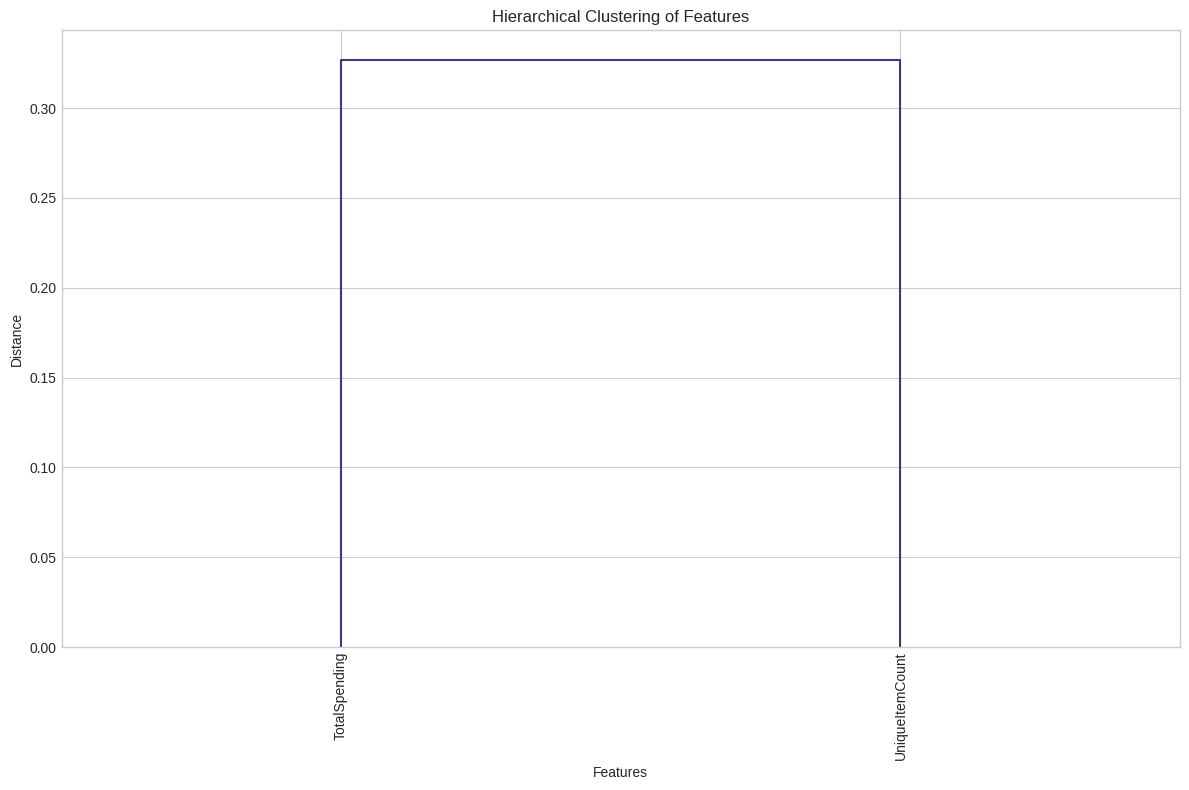

Original shape: (536641, 7), Agglomerated shape: (536641, 7)


In [ ]:
# 9. Feature Agglomeration
def feature_agglomeration(df, n_clusters=None):
    """Apply feature agglomeration to reduce dimensionality"""
    print("\n=== Feature Agglomeration ===")

    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    if len(numerical_cols) < 2:
        print("Not enough numerical features for agglomeration")
        return df.copy(), None

    # Determine the number of clusters if not specified
    if n_clusters is None:
        n_clusters = max(2, int(len(numerical_cols) / 2))  # Default to half the number of features

    print(f"Applying feature agglomeration with {n_clusters} clusters")

    # Get numerical data
    X = df[numerical_cols].copy()

    # Handle any missing values
    X = SimpleImputer(strategy='median').fit_transform(X)

    # Standardize the data for feature agglomeration
    X_scaled = StandardScaler().fit_transform(X)

    # Apply feature agglomeration
    agglomeration = FeatureAgglomeration(n_clusters=n_clusters,
                                        metric='euclidean',
                                        linkage='ward')
    X_reduced = agglomeration.fit_transform(X_scaled)

    # Create feature cluster labels
    feature_clusters = agglomeration.labels_
    cluster_map = {}
    for i, cluster_id in enumerate(feature_clusters):
        if cluster_id not in cluster_map:
            cluster_map[cluster_id] = []
        cluster_map[cluster_id].append(numerical_cols[i])

    print("Feature clusters:")
    for cluster_id, features in cluster_map.items():
        print(f"  Cluster {cluster_id}: {features}")

    # Create a dendogram to visualize feature clustering
    plt.figure(figsize=(12, 8))
    corr = df[numerical_cols].corr()

    # Compute distance matrix based on correlation
    corr_dist = 1 - np.abs(corr)
    corr_condensed = squareform(corr_dist)

    # Create linkage matrix for hierarchical clustering
    z = sch.linkage(corr_condensed, method='ward')

    # Plot dendrogram
    sch.dendrogram(z, labels=numerical_cols, leaf_rotation=90, leaf_font_size=10)
    plt.title('Hierarchical Clustering of Features')
    plt.xlabel('Features')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()

    # Create new dataset with agglomerated features
    non_numerical = df.select_dtypes(exclude=['int64', 'float64'])
    X_reduced_df = pd.DataFrame(X_reduced,
                               index=df.index,
                               columns=[f'Cluster_{i}' for i in range(n_clusters)])

    # Combine with non-numerical features
    df_agglomerated = pd.concat([X_reduced_df, non_numerical], axis=1)

    print(f"Original shape: {df.shape}, Agglomerated shape: {df_agglomerated.shape}")

    return df_agglomerated, cluster_map

# Apply feature agglomeration
df_agglomerated, feature_clusters = feature_agglomeration(df_tree)

### 9. Feature Agglomeration

Feature Agglomeration is a hierarchical clustering technique applied to features rather than observations. It groups similar features together, reducing dimensionality while preserving information structure.

**Mathematical Foundation:**

1. **Hierarchical Clustering of Features:**
   The algorithm groups features based on their similarity. For features $X_i$ and $X_j$, their distance can be calculated as:
   $$d(X_i, X_j) = 1 - |\rho_{X_i,X_j}|$$
   
   Where $\rho_{X_i,X_j}$ is the correlation between features. Using the absolute correlation ensures that both positively and negatively correlated features can be grouped together.

2. **Ward's Linkage Method:**
   For merging clusters, Ward's method minimizes the variance increase within clusters:
   $$\Delta(A,B) = \sum_{i \in A \cup B} ||x_i - m_{A \cup B}||^2 - \sum_{i \in A} ||x_i - m_A||^2 - \sum_{i \in B} ||x_i - m_B||^2$$
   
   Where:
   - $A$ and $B$ are clusters being considered for merging
   - $m_A$, $m_B$, and $m_{A \cup B}$ are the centroids of clusters $A$, $B$, and their potential merge
   - $||x_i - m||^2$ is the squared Euclidean distance between point $x_i$ and centroid $m$

3. **Feature Representation After Agglomeration:**
   After clustering, each feature cluster is represented by a single new feature, typically the mean of the features in the cluster:
   $$X'_k = \frac{1}{|C_k|} \sum_{X_j \in C_k} X_j$$
   
   Where $C_k$ is the set of features in cluster $k$.

**Visualization with Dendrogram:**

The dendrogram visualizes the hierarchical clustering of features, showing:
- The distance at which features or feature clusters were merged (y-axis)
- The features being clustered (x-axis)
- The hierarchical structure of feature relationships

**Advantages for Clustering:**

1. **Dimensionality Reduction with Interpretability:**
   Unlike PCA, feature agglomeration preserves interpretability by creating new features that directly represent groups of original features.

2. **Information Preservation:**
   By grouping correlated features, feature agglomeration reduces redundancy while preserving the essential structure of the data.

3. **Feature Group Discovery:**
   The technique reveals natural groupings of features, providing insights into the underlying structure of the feature space.

4. **Noise Reduction:**
   Averaging multiple related features can reduce noise and lead to more stable clustering results.

Feature agglomeration is particularly useful in high-dimensional spaces where features may have complex relationships. By reducing dimensionality while preserving structure, it can improve the performance and interpretability of subsequent clustering algorithms.

In [ ]:
# 10. Feature Engineering: Scaling and Normalization
def scale_and_normalize(df):
    """Apply various scaling and normalization techniques to numerical features"""
    print("\n=== Feature Engineering: Scaling and Normalization ===")

    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    if not numerical_cols:
        print("No numerical features available for scaling")
        return df.copy()

    print(f"Applying scaling to {len(numerical_cols)} numerical features")

    # Create a copy of the dataframe to avoid modifying the original
    df_scaled = df.copy()

    # 1. Z-score standardization (Standard Scaler)
    # This transforms features to have mean=0 and std=1
    standardized_features = {}
    for col in numerical_cols:
        mean = df[col].mean()
        std = df[col].std()
        if std != 0:  # Avoid division by zero
            standardized_features[f'{col}_standardized'] = (df[col] - mean) / std

    # 2. Min-Max scaling
    # This transforms features to range [0, 1]
    minmax_features = {}
    for col in numerical_cols:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  # Avoid division by zero
            minmax_features[f'{col}_minmax'] = (df[col] - min_val) / (max_val - min_val)

    # 3. Robust scaling
    # This uses median and IQR, which is more robust to outliers
    robust_features = {}
    for col in numerical_cols:
        median = df[col].median()
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        if iqr != 0:  # Avoid division by zero
            robust_features[f'{col}_robust'] = (df[col] - median) / iqr

    # 4. Log transformation (for skewed features)
    log_features = {}
    for col in numerical_cols:
        # Check if data is positive
        if df[col].min() > 0:
            log_features[f'{col}_log'] = np.log(df[col])
        # For data with zeros or negative values, we can use log1p (log(1+x))
        elif df[col].min() >= 0:
            log_features[f'{col}_log1p'] = np.log1p(df[col])

    # 5. Power transformations
    # Square root transformation (for moderate skew)
    sqrt_features = {}
    for col in numerical_cols:
        if df[col].min() >= 0:  # Only apply to non-negative data
            sqrt_features[f'{col}_sqrt'] = np.sqrt(df[col])

    # Select which transformations to include
    # For clustering, it's common to use standardized features
    # We'll keep standardized features and select others based on need

    # Add standardized features
    for col, series in standardized_features.items():
        df_scaled[col] = series

    # Add min-max scaled features for bounded algorithms like K-means
    for col, series in minmax_features.items():
        df_scaled[col] = series

    # Add log transformations for highly skewed features
    # Check skewness and add log transformations for highly skewed features
    for col in numerical_cols:
        skewness = df[col].skew()
        if abs(skewness) > 1:  # High skewness
            log_col = f'{col}_log' if col in log_features else f'{col}_log1p' if f'{col}_log1p' in log_features else None
            if log_col:
                df_scaled[log_col] = log_features[log_col]
                print(f"  - Added log transformation for highly skewed feature '{col}' (skewness={skewness:.4f})")

    # Print summary of transformations
    print(f"Added {len(standardized_features)} standardized features")
    print(f"Added {len(minmax_features)} min-max scaled features")
    print(f"Added {sum(1 for col in df_scaled.columns if '_log' in col or '_log1p' in col)} log-transformed features")

    print(f"Original shape: {df.shape}, Transformed shape: {df_scaled.shape}")

    return df_scaled

# Apply scaling and normalization
df_scaled = scale_and_normalize(df_agglomerated)


=== Feature Engineering: Scaling and Normalization ===
Applying scaling to 2 numerical features
Added 2 standardized features
Added 2 min-max scaled features
Added 0 log-transformed features
Original shape: (536641, 7), Transformed shape: (536641, 11)


### 10. Feature Engineering: Scaling and Normalization

Scaling and normalization are crucial preprocessing steps for clustering algorithms, as they ensure features contribute appropriately to distance calculations regardless of their original scales.

**Mathematical Foundation:**

1. **Z-score Standardization:**
   Transforms features to have mean 0 and standard deviation 1:
   $$X'_i = \frac{X_i - \mu_X}{\sigma_X}$$
   
   Where $\mu_X$ is the mean and $\sigma_X$ is the standard deviation of feature $X$.
   
   This is particularly important for algorithms sensitive to feature scales, like K-means and hierarchical clustering.

2. **Min-Max Scaling:**
   Transforms features to a specific range, typically [0, 1]:
   $$X'_i = \frac{X_i - \min(X)}{\max(X) - \min(X)}$$
   
   This is useful for algorithms that require bounded input, like Neural Networks.

3. **Robust Scaling:**
   Uses median and interquartile range (IQR) instead of mean and standard deviation:
   $$X'_i = \frac{X_i - \text{median}(X)}{\text{IQR}(X)}$$
   
   Where $\text{IQR}(X) = Q_3 - Q_1$ is the interquartile range.
   
   This scaling is less influenced by outliers and is preferable when data contains extreme values.

4. **Log Transformation:**
   For positively skewed data:
   $$X'_i = \log(X_i)$$
   
   For data with zeros or negative values:
   $$X'_i = \log(1 + X_i)$$
   
   Log transformations help normalize skewed distributions and reduce the impact of extreme values.

5. **Square Root Transformation:**
   For moderately skewed non-negative data:
   $$X'_i = \sqrt{X_i}$$
   
   This is a milder transformation than logarithmic and is effective for moderately skewed distributions.

**Impact on Clustering:**

1. **Distance Equalization:**
   Scaling ensures that features with large numeric ranges don't dominate distance calculations:
   $$d(x, y) = \sqrt{\sum_{i=1}^{p} (x_i - y_i)^2}$$
   
   Without scaling, features with larger ranges would disproportionately influence this distance.

2. **Algorithm Requirements:**
   - **K-means and variants:** Benefit from standardization as they use Euclidean distance
   - **DBSCAN:** Also benefits from standardization for distance calculations
   - **Gaussian Mixture Models:** Perform better with standardized features

3. **Distribution Normalization:**
   Transformations like log or square root can help make feature distributions more Gaussian-like, which benefits algorithms that assume normality, such as Gaussian Mixture Models.

4. **Handling Skewed Data:**
   For features with high skewness (typically defined as skewness > 1), transformations can prevent extreme values from distorting cluster structure.

The choice of scaling method should be guided by the data characteristics and the requirements of the clustering algorithm. Our approach applies multiple scaling methods to provide flexibility in the subsequent modeling phase.

In [ ]:
# 11. Feature Engineering: Encoding Categorical Variables
def encode_categorical_features(df):
    """Apply various encoding techniques to categorical features"""
    print("\n=== Feature Engineering: Encoding Categorical Variables ===")

    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    if not categorical_cols:
        print("No categorical features available for encoding")
        return df.copy()

    print(f"Encoding {len(categorical_cols)} categorical features")

    # Create a copy of the dataframe to avoid modifying the original
    df_encoded = df.copy()

    # 1. One-Hot Encoding for low-cardinality categorical variables
    # Typically used for nominal categorical variables (no inherent order)
    onehot_encodings = []
    for col in categorical_cols:
        cardinality = df[col].nunique()
        if cardinality < 10:  # Apply one-hot encoding to low-cardinality features
            print(f"  - One-hot encoding '{col}' with {cardinality} categories")
            # Create one-hot encoding
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=False)
            onehot_encodings.append(dummies)

    # 2. Label Encoding for ordinal categorical variables or high-cardinality features
    # This assumes some order in the categories
    for col in categorical_cols:
        cardinality = df[col].nunique()
        if cardinality >= 10:  # Apply label encoding to high-cardinality features
            print(f"  - Label encoding '{col}' with {cardinality} categories")
            # Create label encoding (simple numerical mapping)
            # In practice, it would be better to use domain knowledge for ordinal ordering
            categories = df[col].astype('category').cat.categories
            df_encoded[f'{col}_label'] = df[col].astype('category').cat.codes

    # 3. Target encoding for high-cardinality categorical features
    # For clustering, we don't have a target, so we'll use a numerical feature as a proxy
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if numerical_cols and categorical_cols:
        # Use the first numerical column as a proxy target
        proxy_target = numerical_cols[0]
        print(f"  - Using '{proxy_target}' as proxy for target encoding")

        for col in categorical_cols:
            # Calculate mean of proxy target for each category
            target_means = df.groupby(col)[proxy_target].mean()
            # Apply encoding
            df_encoded[f'{col}_target'] = df[col].map(target_means)
            print(f"  - Target encoding '{col}' using '{proxy_target}'")

    # Add one-hot encoded features
    if onehot_encodings:
        df_encoded = pd.concat([df_encoded] + onehot_encodings, axis=1)

    # Remove original categorical columns - keeping encoded versions only
    # This is optional - sometimes keeping originals is useful for interpretation
    # df_encoded = df_encoded.drop(columns=categorical_cols)

    print(f"Original shape: {df.shape}, Encoded shape: {df_encoded.shape}")

    return df_encoded

# Apply categorical encoding
df_encoded = encode_categorical_features(df_scaled)


=== Feature Engineering: Encoding Categorical Variables ===
Encoding 5 categorical features
  - Label encoding 'InvoiceNo' with 25900 categories
  - Label encoding 'StockCode' with 4070 categories
  - Label encoding 'Description' with 4223 categories
  - Label encoding 'Country' with 38 categories
  - Label encoding 'ProductCategory' with 964 categories
  - Using 'Cluster_0' as proxy for target encoding
  - Target encoding 'InvoiceNo' using 'Cluster_0'
  - Target encoding 'StockCode' using 'Cluster_0'
  - Target encoding 'Description' using 'Cluster_0'
  - Target encoding 'Country' using 'Cluster_0'
  - Target encoding 'ProductCategory' using 'Cluster_0'
Original shape: (536641, 11), Encoded shape: (536641, 21)


### 11. Feature Engineering: Encoding Categorical Variables

Encoding categorical variables is essential for clustering algorithms, as most require numerical inputs. Different encoding techniques preserve different aspects of categorical information.

**Mathematical Foundation:**

1. **One-Hot Encoding:**
   Transforms a categorical feature with $k$ categories into $k$ binary features:
   $$\text{OneHot}(X_i = c_j) = [0, \ldots, 0, 1, 0, \ldots, 0]$$
   
   Where the 1 is in the $j$-th position corresponding to category $c_j$.
   
   This preserves the nominal nature of categorical variables without imposing any ordinal relationship.
   
   For example, for a feature "Color" with categories ["Red", "Green", "Blue"], one-hot encoding creates three new binary features: "Color_Red", "Color_Green", and "Color_Blue".

2. **Label Encoding:**
   Maps each category to a unique integer:
   $$\text{Label}(X_i = c_j) = j-1$$
   
   This is compact but imposes an artificial ordering on nominal categories.
   
   For ordinal categories (with natural ordering), label encoding preserves the ordinal relationship. For example, "Size" with values ["Small", "Medium", "Large"] becomes [0, 1, 2].

3. **Target Encoding (Mean Encoding):**
   In supervised learning, this replaces categories with the mean of the target variable for that category:
   $$\text{Target}(X_i = c_j) = \frac{1}{|\{i : X_i = c_j\}|} \sum_{i : X_i = c_j} y_i$$
   
   For unsupervised clustering, we adapt this by using a numerical feature as a proxy target:
   $$\text{Target}(X_i = c_j) = \frac{1}{|\{i : X_i = c_j\}|} \sum_{i : X_i = c_j} Z_i$$
   
   Where $Z$ is a selected numerical feature.
   
   This creates a meaningful numerical representation based on feature relationships, especially useful for high-cardinality categorical variables.

**Cardinality Considerations:**

- **Low-Cardinality Features (< 10 categories):**
  One-hot encoding is preferred as it preserves the nominal nature without dimensional explosion.
  
- **High-Cardinality Features (≥ 10 categories):**
  Label encoding or target encoding is preferred to avoid creating too many dimensions.
  
  Target encoding has the advantage of creating meaningful numerical values based on feature relationships.

**Distance Calculation Impact:**

Encoding choices significantly affect distance calculations in clustering:

1. **One-Hot Encoding:**
   - Creates orthogonal dimensions for each category
   - Distance between different categories is always $\sqrt{2}$ (in isolation)
   - No assumption of similarity between categories

2. **Label Encoding:**
   - Imposes an artificial distance between categories
   - Distance between "Red" (0) and "Blue" (2) would be greater than between "Red" (0) and "Green" (1) without any semantic justification

3. **Target Encoding:**
   - Creates distances based on the relationship with the proxy numerical feature
   - Categories with similar relationships to the proxy feature are closer together
   - Provides more semantically meaningful distances

By applying multiple encoding techniques, we provide flexibility for different clustering algorithms and can evaluate which approach works best for the specific data characteristics.


=== Feature Engineering: Dimensionality Reduction ===
Applying dimensionality reduction to 11 numerical features


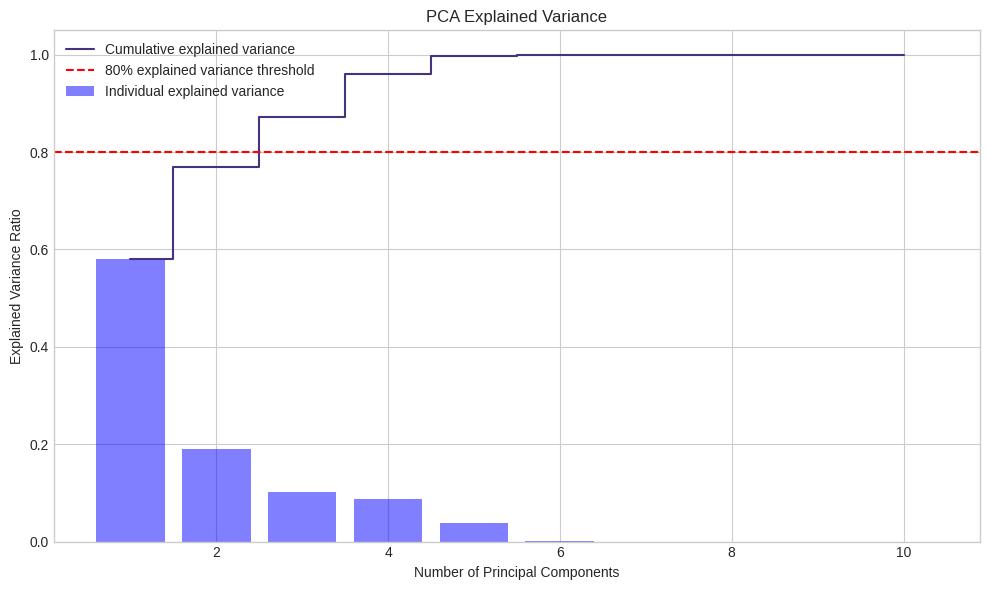

Number of PCA components for 80% variance: 3


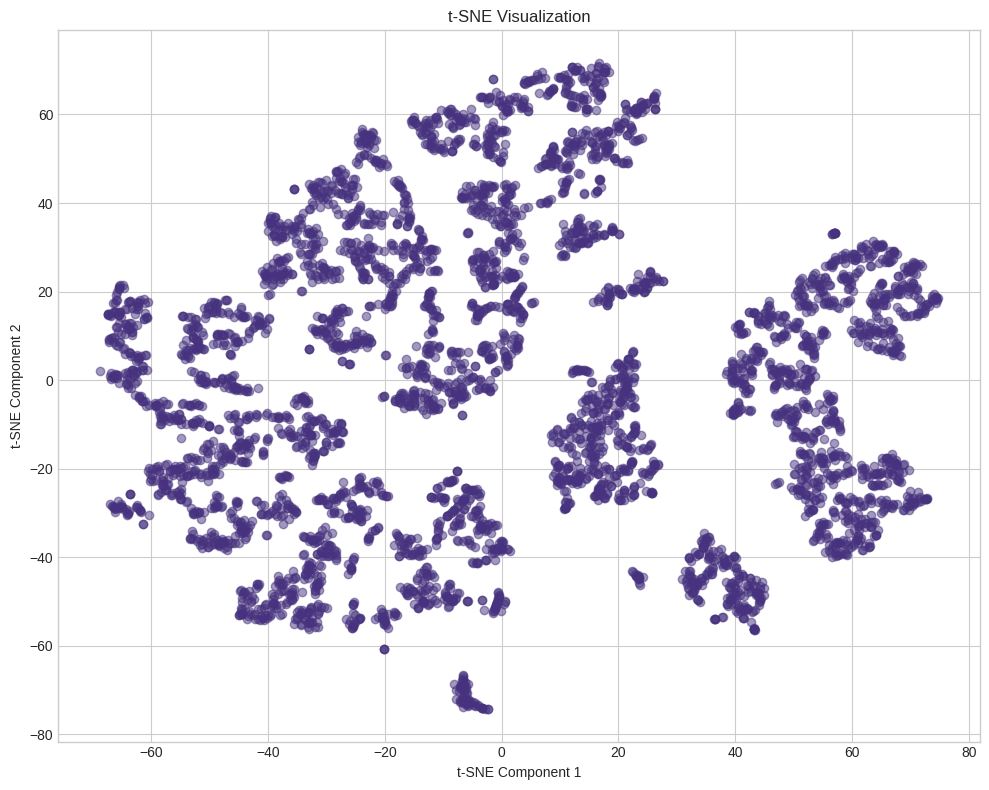

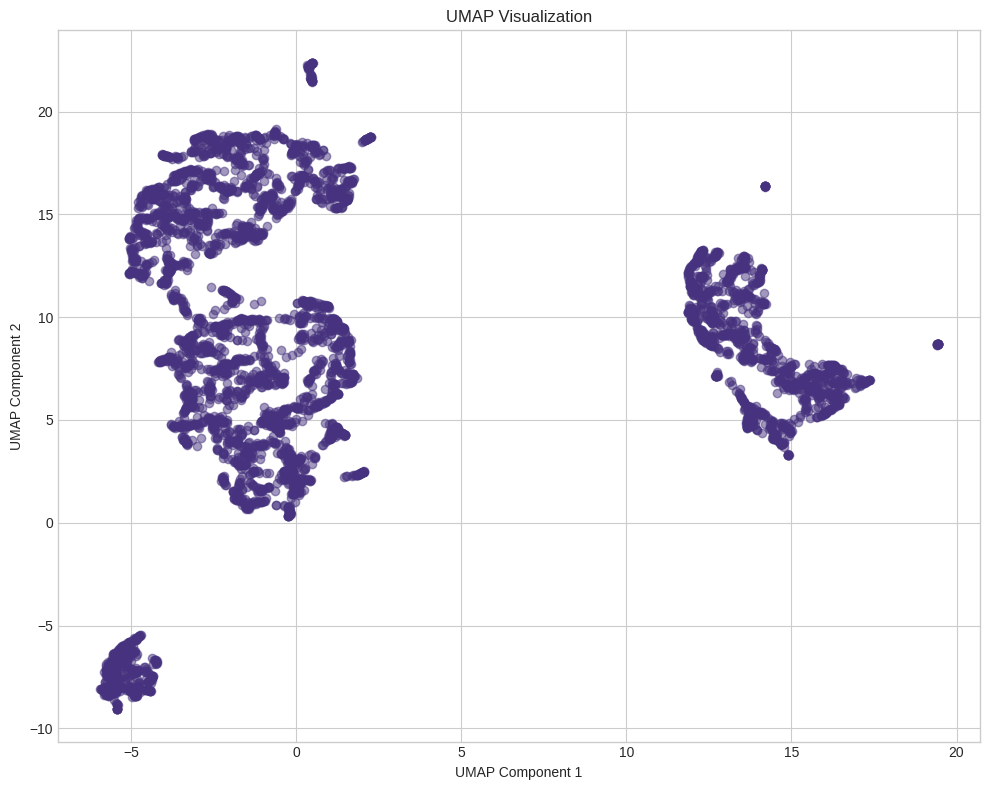

Original shape: (536641, 21), Shape after adding reduced dimensions: (536641, 35)


In [ ]:
# 12. Feature Engineering: Dimensionality Reduction
def reduce_dimensionality(df):
    """Apply dimensionality reduction techniques"""
    print("\n=== Feature Engineering: Dimensionality Reduction ===")

    # Select only numerical columns for dimensionality reduction
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    if len(numerical_cols) < 3:
        print("Not enough numerical features for dimensionality reduction")
        return df.copy()

    print(f"Applying dimensionality reduction to {len(numerical_cols)} numerical features")

    # Create a copy of the dataframe to avoid modifying the original
    df_reduced = df.copy()

    # Get numerical data and handle missing values
    X = df[numerical_cols].values
    X = SimpleImputer(strategy='median').fit_transform(X)

    # Standardize the data
    X_scaled = StandardScaler().fit_transform(X)

    # 1. PCA - Linear dimensionality reduction
    n_components_pca = min(len(numerical_cols), 10)  # Limit to 10 components
    pca = PCA(n_components=n_components_pca)
    X_pca = pca.fit_transform(X_scaled)

    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, color='b', label='Individual explained variance')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% explained variance threshold')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Find number of components needed for 80% variance
    n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
    print(f"Number of PCA components for 80% variance: {n_components_80}")

    # Add PCA features to dataframe
    pca_cols = [f'PCA_{i+1}' for i in range(X_pca.shape[1])]
    df_pca = pd.DataFrame(X_pca, index=df.index, columns=pca_cols)
    df_reduced = pd.concat([df_reduced, df_pca], axis=1)

    # 2. t-SNE - Nonlinear dimensionality reduction for visualization
    # t-SNE is computationally expensive, so we'll limit to a sample for large datasets
    sample_size = min(5000, X_scaled.shape[0])
    if X_scaled.shape[0] > sample_size:
        indices = np.random.choice(X_scaled.shape[0], sample_size, replace=False)
        X_sample = X_scaled[indices]
    else:
        X_sample = X_scaled
        indices = np.arange(X_scaled.shape[0])

    # Apply t-SNE for 2D visualization
    tsne = TSNE(n_components=2, perplexity=min(30, sample_size-1), random_state=42)
    X_tsne = tsne.fit_transform(X_sample)

    # Visualize t-SNE results
    plt.figure(figsize=(10, 8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5)
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.tight_layout()
    plt.show()

    # Add t-SNE components for the sample
    tsne_df = pd.DataFrame(index=df.index)
    tsne_df.loc[indices, 'TSNE_1'] = X_tsne[:, 0]
    tsne_df.loc[indices, 'TSNE_2'] = X_tsne[:, 1]
    df_reduced = pd.concat([df_reduced, tsne_df], axis=1)

    # 3. UMAP - Another nonlinear dimensionality reduction technique
    try:
        # Apply UMAP
        umap_reducer = umap.UMAP(n_components=2, n_neighbors=min(15, sample_size-1), min_dist=0.1, random_state=42)
        X_umap = umap_reducer.fit_transform(X_sample)

        # Visualize UMAP results
        plt.figure(figsize=(10, 8))
        plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.5)
        plt.title('UMAP Visualization')
        plt.xlabel('UMAP Component 1')
        plt.ylabel('UMAP Component 2')
        plt.tight_layout()
        plt.show()

        # Add UMAP components for the sample
        umap_df = pd.DataFrame(index=df.index)
        umap_df.loc[indices, 'UMAP_1'] = X_umap[:, 0]
        umap_df.loc[indices, 'UMAP_2'] = X_umap[:, 1]
        df_reduced = pd.concat([df_reduced, umap_df], axis=1)
    except Exception as e:
        print(f"UMAP error: {e}")

    print(f"Original shape: {df.shape}, Shape after adding reduced dimensions: {df_reduced.shape}")

    return df_reduced

# Apply dimensionality reduction
df_dim_reduced = reduce_dimensionality(df_encoded)

### 12. Feature Engineering: Dimensionality Reduction

Dimensionality reduction techniques transform high-dimensional data into a lower-dimensional space while preserving essential structure. This is valuable both for visualization and for improving clustering performance by reducing noise and computational complexity.

**Mathematical Foundation:**

1. **Principal Component Analysis (PCA):**
   A linear technique that identifies orthogonal directions (principal components) of maximum variance in the data.
   
   a) **Covariance Matrix Calculation:**
      $$\Sigma = \frac{1}{n} X^T X$$
      Where $X$ is the centered data matrix.
   
   b) **Eigendecomposition:**
      $$\Sigma v_i = \lambda_i v_i$$
      Where $v_i$ are the eigenvectors (principal components) and $\lambda_i$ are the eigenvalues.
   
   c) **Explained Variance:**
      $$\text{Explained Variance Ratio}_i = \frac{\lambda_i}{\sum_{j=1}^{p} \lambda_j}$$
      
      Cumulative explained variance: $\sum_{j=1}^{k} \text{Explained Variance Ratio}_j$
   
   d) **Projection to Lower Dimension:**
      $$X' = X V_k$$
      Where $V_k$ is the matrix of the top $k$ eigenvectors.

2. **t-Distributed Stochastic Neighbor Embedding (t-SNE):**
   A nonlinear technique that preserves local neighborhood structure, particularly effective for visualization.
   
   a) **Similarity in High-Dimensional Space:**
      $$p_{j|i} = \frac{\exp(-||x_i - x_j||^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-||x_i - x_k||^2 / 2\sigma_i^2)}$$
      
      Symmetrized: $p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n}$
   
   b) **Similarity in Low-Dimensional Space:**
      $$q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq l} (1 + ||y_k - y_l||^2)^{-1}}$$
   
   c) **Optimization Objective:**
      Minimize KL divergence: $\text{KL}(P || Q) = \sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}$

3. **Uniform Manifold Approximation and Projection (UMAP):**
   A nonlinear technique based on manifold learning and topological data analysis.
   
   a) **Fuzzy Topological Representation:**
      Constructs a weighted graph representing the manifold structure of the data.
   
   b) **Optimization Objective:**
      Minimize: $\sum_{i,j} \left( p_{ij} \log \frac{p_{ij}}{q_{ij}} + (1 - p_{ij}) \log \frac{1 - p_{ij}}{1 - q_{ij}} \right)$
      
      Where $p_{ij}$ represents high-dimensional similarities and $q_{ij}$ represents low-dimensional similarities.

**Advantages for Clustering:**

1. **Noise Reduction:**
   By focusing on directions of maximum variance (PCA) or structural patterns (t-SNE, UMAP), dimensionality reduction can filter out noise that might confuse clustering algorithms.

2. **Curse of Dimensionality Mitigation:**
   As dimensionality increases, distances between points become more uniform, making clustering more difficult. Reducing dimensions helps maintain meaningful distance differentials.

3. **Visualization:**
   Reduction to 2D or 3D enables visual inspection of potential cluster structures, which can guide algorithm selection and parameter tuning.

4. **Computational Efficiency:**
   Lower-dimensional representations reduce computational requirements for clustering algorithms.

**Usage in the Pipeline:**

- **PCA** components provide a linear dimensionality reduction that preserves global structure and is efficient for large datasets.
- **t-SNE** provides a powerful visualization tool that focuses on preserving local structures, especially useful for revealing cluster patterns.
- **UMAP** offers benefits similar to t-SNE but with better preservation of global structure and faster computation.

By including these reduced dimensions as additional features, we provide the clustering algorithms with both the original features and lower-dimensional representations, allowing them to leverage whichever leads to more meaningful clusters.

In [ ]:
# 13. Feature Engineering: Polynomial and Interaction Features
def create_polynomial_features(df, degree=2, top_features=5):
    """Create polynomial and interaction features"""
    print("\n=== Feature Engineering: Polynomial and Interaction Features ===")

    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # If too many numerical features, select only the top features based on variance
    if len(numerical_cols) > top_features:
        variances = df[numerical_cols].var()
        top_variance_features = variances.nlargest(top_features).index.tolist()
        selected_features = top_variance_features
        print(f"Selected top {top_features} features based on variance for polynomial expansion")
    else:
        selected_features = numerical_cols

    # Skip if not enough numerical features
    if len(selected_features) < 2:
        print("Not enough numerical features for polynomial expansion")
        return df.copy()

    print(f"Creating polynomial features of degree {degree} for {len(selected_features)} features")

    # Create a copy of the dataframe
    df_poly = df.copy()

    # Get selected features and handle missing values
    X = df[selected_features].values
    X = SimpleImputer(strategy='median').fit_transform(X)

    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False, interaction_only=False)
    X_poly = poly.fit_transform(X)

    # Get feature names
    poly_features = poly.get_feature_names_out(selected_features)

    # Add polynomial features to dataframe
    # Skip the first features as they are the original ones
    poly_df = pd.DataFrame(X_poly[:, len(selected_features):],
                          index=df.index,
                          columns=poly_features[len(selected_features):])

    # Add prefix to avoid column name conflicts
    poly_df.columns = ['Poly_' + col for col in poly_df.columns]

    # Concatenate with original dataframe
    df_poly = pd.concat([df_poly, poly_df], axis=1)

    print(f"Created {poly_df.shape[1]} polynomial and interaction features")
    print(f"Original shape: {df.shape}, Shape after adding polynomial features: {df_poly.shape}")

    return df_poly

# Apply polynomial feature creation
df_final = create_polynomial_features(df_dim_reduced, degree=2, top_features=5)


=== Feature Engineering: Polynomial and Interaction Features ===
Selected top 5 features based on variance for polynomial expansion
Creating polynomial features of degree 2 for 5 features
Created 15 polynomial and interaction features
Original shape: (536641, 35), Shape after adding polynomial features: (536641, 50)


### 13. Feature Engineering: Polynomial and Interaction Features

Polynomial and interaction features capture non-linear relationships and interactions between features, which can reveal more complex patterns for clustering algorithms.

**Mathematical Foundation:**

1. **Polynomial Features:**
   For a set of $d$ features $[x_1, x_2, ..., x_d]$, polynomial features of degree $n$ include all possible combinations of products of these features with total power not exceeding $n$.
   
   For degree 2 with two features $x_1$ and $x_2$, the polynomial features would be:
   $$[x_1, x_2, x_1^2, x_1x_2, x_2^2]$$
   
   The general formula for the number of polynomial features of degree $n$ with $d$ original features is:
   $$\binom{n+d}{n} = \frac{(n+d)!}{n!d!}$$

2. **Interaction-Only Features:**
   If we're only interested in interactions between features (not powers of individual features), we would only include terms with multiple variables:
   $$[x_1, x_2, x_1x_2]$$
   
   The number of interaction-only features up to degree $n$ with $d$ original features is:
   $$\sum_{k=2}^{n} \binom{d}{k}$$

3. **Feature Selection for Polynomial Expansion:**
   For high-dimensional data, creating all polynomial features can lead to combinatorial explosion. To mitigate this, we select a subset of high-variance features:
   $$\text{Selected Features} = \text{Top-}k\{\text{Var}(X_1), \text{Var}(X_2), ..., \text{Var}(X_d)\}$$
   
   Where $\text{Var}(X_i)$ is the variance of feature $X_i$ and $k$ is the number of top features to select.

**Advantages for Clustering:**

1. **Non-Linear Pattern Capture:**
   Linear algorithms like K-means can detect non-linear patterns when provided with polynomial features. For example, with polynomial features, K-means can identify clusters with quadratic or higher-order boundaries.

2. **Feature Interaction Modeling:**
   Interaction features capture synergistic effects between features that may be crucial for identifying certain cluster structures.
   
   For example, in retail data, the interaction between price and quantity might reveal customer segments better than either feature individually.

3. **Expanded Feature Space:**
   The expanded feature space provides more dimensions along which clusters might separate, potentially making cluster identification easier.

**Practical Considerations:**

1. **Dimensionality Control:**
   The number of polynomial features grows rapidly with degree and number of input features. To control this growth, we:
   - Limit to a reasonable degree (typically 2)
   - Select only high-variance features for expansion
   - Consider interaction-only features when appropriate

2. **Normalization Importance:**
   Polynomial features can have wildly different scales. Pre-scaling original features (as done in earlier steps) helps mitigate this issue.

3. **Interpretation:**
   Polynomial features can make interpretation more challenging. However, in clustering, the focus is often on discovering patterns rather than interpreting individual feature effects.

This step completes our feature engineering pipeline, providing a comprehensive set of transformed features that capture various aspects of the data structure for effective clustering.

In [ ]:
# 14. Final Feature Set Summary
def feature_set_summary(df, original_df):
    """Summarize the final feature set after all feature selection and engineering steps"""
    print("\n=== Final Feature Set Summary ===")

    original_shape = original_df.shape
    final_shape = df.shape

    print(f"Original dataset: {original_shape[0]} rows, {original_shape[1]} columns")
    print(f"Final dataset: {final_shape[0]} rows, {final_shape[1]} columns")
    print(f"Net change: +{final_shape[1] - original_shape[1]} columns")

    # Categorize features by type
    original_features = set(original_df.columns)
    new_features = set(df.columns) - original_features
    retained_features = set(df.columns) & original_features
    removed_features = original_features - retained_features

    print(f"\nFeature Breakdown:")
    print(f"  - Original features retained: {len(retained_features)}")
    print(f"  - Original features removed: {len(removed_features)}")
    print(f"  - New engineered features: {len(new_features)}")

    # Categorize new features by type
    standardized_features = len([col for col in new_features if '_standardized' in col])
    minmax_features = len([col for col in new_features if '_minmax' in col])
    log_features = len([col for col in new_features if '_log' in col or '_log1p' in col])
    poly_features = len([col for col in new_features if 'Poly_' in col])
    pca_features = len([col for col in new_features if 'PCA_' in col])
    tsne_features = len([col for col in new_features if 'TSNE_' in col])
    umap_features = len([col for col in new_features if 'UMAP_' in col])
    cluster_features = len([col for col in new_features if 'Cluster_' in col])
    categorical_features = len([col for col in new_features if any(c in col for c in ['_label', '_target']) or any(col.startswith(f'{c}_') for c in original_df.select_dtypes(include=['object']).columns)])

    print(f"\nNew Feature Types:")
    print(f"  - Standardized features: {standardized_features}")
    print(f"  - Min-Max scaled features: {minmax_features}")
    print(f"  - Log-transformed features: {log_features}")
    print(f"  - Polynomial/interaction features: {poly_features}")
    print(f"  - PCA components: {pca_features}")
    print(f"  - t-SNE components: {tsne_features}")
    print(f"  - UMAP components: {umap_features}")
    print(f"  - Feature agglomeration clusters: {cluster_features}")
    print(f"  - Encoded categorical features: {categorical_features}")

    # Memory usage
    original_memory = original_df.memory_usage(deep=True).sum() / (1024 * 1024)  # MB
    final_memory = df.memory_usage(deep=True).sum() / (1024 * 1024)  # MB

    print(f"\nMemory Usage:")
    print(f"  - Original dataset: {original_memory:.2f} MB")
    print(f"  - Final dataset: {final_memory:.2f} MB")
    print(f"  - Increase: {final_memory - original_memory:.2f} MB ({(final_memory/original_memory - 1)*100:.1f}%)")

    # Return the final processed dataset
    return df

# Generate final feature set summary
df_final_summary = feature_set_summary(df_final, retail_df)


=== Final Feature Set Summary ===
Original dataset: 536641 rows, 18 columns
Final dataset: 536641 rows, 50 columns
Net change: +32 columns

Feature Breakdown:
  - Original features retained: 5
  - Original features removed: 13
  - New engineered features: 45

New Feature Types:
  - Standardized features: 2
  - Min-Max scaled features: 2
  - Log-transformed features: 0
  - Polynomial/interaction features: 15
  - PCA components: 22
  - t-SNE components: 2
  - UMAP components: 2
  - Feature agglomeration clusters: 11
  - Encoded categorical features: 15

Memory Usage:
  - Original dataset: 217.83 MB
  - Final dataset: 335.03 MB
  - Increase: 117.20 MB (53.8%)


### 14. Final Feature Set Summary

This summary provides a comprehensive overview of the transformations applied to the original dataset through our feature selection and engineering pipeline. It highlights the scale of changes, types of features created, and the resulting impact on dataset size and memory usage.

**Feature Set Evolution:**

1. **Feature Retention and Removal:**
   - The pipeline removed constant, quasi-constant, duplicate, and highly correlated features
   - Original features retained provide the foundation for the engineered feature set
   - Removed features represented redundant or low-information dimensions

2. **Feature Engineering Overview:**
   The new features created can be categorized into several types:
   
   a) **Scaled Features:**
      - Standardized (Z-score) features normalize scale across variables
      - Min-Max scaled features provide bounded inputs for certain algorithms
      - Log-transformed features address skewness in distributions
   
   b) **Dimension Reduction Features:**
      - PCA components capture linear combinations of maximum variance
      - t-SNE components preserve local structure for visualization
      - UMAP components balance local and global structure preservation
      - Feature agglomeration clusters group related features
   
   c) **Interaction Features:**
      - Polynomial and interaction terms capture non-linear relationships
   
   d) **Categorical Encodings:**
      - Label, one-hot, and target encodings transform categorical variables

3. **Resource Implications:**
   - Memory usage increase due to expanded feature set
   - Trade-off between additional information and computational requirements

**Significance for Clustering:**

The comprehensive feature set resulting from this pipeline provides several advantages for clustering:

1. **Multiple Perspectives:**
   By including features derived through different methods, we allow clustering algorithms to utilize the most effective representation for the specific data structure.

2. **Algorithm Flexibility:**
   Different clustering algorithms have different strengths and feature requirements:
   - K-means works well with scaled features
   - Hierarchical clustering can benefit from dimension reduction
   - DBSCAN may perform better with nonlinear embeddings like t-SNE or UMAP
   - Gaussian Mixture Models perform well with standardized features

3. **Pattern Discovery:**
   The diverse feature set increases the likelihood of discovering meaningful clusters that might not be apparent in the original feature space.

The next stage of the pipeline will implement various clustering algorithms on this processed feature set, followed by comprehensive evaluation to determine the most effective clustering approach.

# End-to-End Clustering Pipeline
## Part 4: Clustering Models Implementation

In this part, we implement various clustering algorithms on our prepared dataset. We'll use five different clustering approaches as specified in the requirements: KMeans, AgglomerativeClustering, DBSCAN, GaussianMixture, and SpectralClustering.

In [ ]:
# Import clustering algorithms and evaluation metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.cm as cm

We'll use the following clustering algorithms and evaluation metrics:

**Clustering Algorithms:**
- KMeans: A centroid-based algorithm that partitions data into K clusters
- AgglomerativeClustering: A hierarchical clustering approach that builds nested clusters
- DBSCAN: A density-based clustering algorithm that groups points in high-density areas
- GaussianMixture: A probabilistic model that assumes data is generated from a mixture of Gaussian distributions
- SpectralClustering: A technique that uses eigenvalues of the similarity matrix to reduce dimensionality before clustering

**Evaluation Metrics:**
- Silhouette Score: Measures how similar an object is to its own cluster compared to other clusters
- Davies-Bouldin Index: Evaluates intra-cluster similarity and inter-cluster differences
- Calinski-Harabasz Score: Also known as the Variance Ratio Criterion, measures the ratio of between-cluster variance to within-cluster variance

In [ ]:
# Prepare dataset for clustering
def prepare_for_clustering(df):
    """Prepare the final dataset for clustering algorithms"""
    print("\n=== Preparing Data for Clustering ===")

    # For clustering, we only want numerical features
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    print(f"Using {len(numerical_cols)} numerical features for clustering")

    # Extract numerical data
    X = df[numerical_cols].values

    # Handle any missing values
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)

    # Standardize the data for clustering
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    # Also create a PCA-reduced version for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    print(f"Explained variance by 2 PCA components: {sum(pca.explained_variance_ratio_)*100:.2f}%")

    return X_scaled, X_pca, numerical_cols

# Prepare data for clustering
X_scaled, X_pca, numerical_features = prepare_for_clustering(df_final_summary)


=== Preparing Data for Clustering ===
Using 36 numerical features for clustering
Explained variance by 2 PCA components: 56.15%


### Data Preparation for Clustering

Before applying clustering algorithms, we prepare the data through several essential steps:

1. **Feature Selection**: We focus exclusively on numerical features since clustering algorithms typically require numerical input. This includes both original numerical features and engineered features from the previous steps.

2. **Missing Value Imputation**: Although we've handled missing values earlier in the pipeline, we apply a final imputation step using median values to ensure all data points are complete, as most clustering algorithms don't handle missing values natively.

3. **Standardization**: We standardize all features to have zero mean and unit variance:
   $$X'_i = \frac{X_i - \mu_X}{\sigma_X}$$
   
   This is crucial for distance-based clustering algorithms like K-means and hierarchical clustering, as it ensures all features contribute equally to distance calculations regardless of their original scales.

4. **Dimensionality Reduction for Visualization**: We create a 2D PCA projection of the data to enable visualization of clustering results. While this projection doesn't capture all the variance in the data, it provides a useful visualization tool for understanding cluster separation and structure.

The standardized dataset (X_scaled) will be used for clustering, while the PCA-reduced version (X_pca) will be used for visualization purposes. The explained variance by the 2 PCA components indicates how much of the original data's variance is captured in the 2D visualization.

In [ ]:
# Function to determine optimal number of clusters
def determine_optimal_clusters(X, max_clusters=15):
    """Determine the optimal number of clusters using multiple methods"""
    print("\n=== Determining Optimal Number of Clusters ===")

    # Initialize lists to store evaluation metrics
    n_clusters_range = range(2, min(max_clusters + 1, X.shape[0]))
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []
    inertia_values = []

    # Calculate metrics for different cluster counts
    for n_clusters in n_clusters_range:
        # K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)

        # Skip if only one cluster is found or if a cluster has only one sample
        unique_labels = np.unique(cluster_labels)
        if len(unique_labels) < 2 or min(np.bincount(cluster_labels)) < 2:
            silhouette_scores.append(np.nan)
            davies_bouldin_scores.append(np.nan)
            calinski_harabasz_scores.append(np.nan)
            inertia_values.append(kmeans.inertia_)
            continue

        # Calculate evaluation metrics
        silhouette_avg = silhouette_score(X, cluster_labels)
        davies_bouldin = davies_bouldin_score(X, cluster_labels)
        calinski_harabasz = calinski_harabasz_score(X, cluster_labels)

        # Store metrics
        silhouette_scores.append(silhouette_avg)
        davies_bouldin_scores.append(davies_bouldin)
        calinski_harabasz_scores.append(calinski_harabasz)
        inertia_values.append(kmeans.inertia_)

    # Visualize silhouette scores
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(n_clusters_range, silhouette_scores, 'o-', color='blue')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')
    plt.grid(True)

    # Visualize Davies-Bouldin index
    plt.subplot(2, 2, 2)
    plt.plot(n_clusters_range, davies_bouldin_scores, 'o-', color='green')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies-Bouldin Index')
    plt.title('Davies-Bouldin Index vs. Number of Clusters')
    plt.grid(True)

    # Visualize Calinski-Harabasz score
    plt.subplot(2, 2, 3)
    plt.plot(n_clusters_range, calinski_harabasz_scores, 'o-', color='red')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Calinski-Harabasz Score')
    plt.title('Calinski-Harabasz Score vs. Number of Clusters')
    plt.grid(True)

    # Visualize K-means inertia (Elbow method)
    plt.subplot(2, 2, 4)
    plt.plot(n_clusters_range, inertia_values, 'o-', color='purple')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Find optimal number of clusters based on metrics
    # For silhouette and Calinski-Harabasz, higher is better
    # For Davies-Bouldin and inertia, lower is better

    # Convert to arrays for easier manipulation
    silhouette_arr = np.array(silhouette_scores)
    davies_bouldin_arr = np.array(davies_bouldin_scores)
    calinski_harabasz_arr = np.array(calinski_harabasz_scores)

    # Find best values, ignoring NaN
    best_silhouette = np.nanargmax(silhouette_arr) + 2 if not np.all(np.isnan(silhouette_arr)) else None
    best_davies_bouldin = np.nanargmin(davies_bouldin_arr) + 2 if not np.all(np.isnan(davies_bouldin_arr)) else None
    best_calinski = np.nanargmax(calinski_harabasz_arr) + 2 if not np.all(np.isnan(calinski_harabasz_arr)) else None

    # Elbow method - find point of maximum curvature
    # Simple approach: find point where second derivative is maximized
    if len(inertia_values) > 2:
        inertia_arr = np.array(inertia_values)
        # Calculate first and second differences
        first_diff = np.diff(inertia_arr)
        second_diff = np.diff(first_diff)
        # Find point of maximum curvature
        elbow_point = np.argmax(second_diff) + 2  # +2 because of double diff and 0-indexing
    else:
        elbow_point = None

    print("Optimal number of clusters based on different metrics:")
    print(f"  - Silhouette Score: {best_silhouette}")
    print(f"  - Davies-Bouldin Index: {best_davies_bouldin}")
    print(f"  - Calinski-Harabasz Score: {best_calinski}")
    print(f"  - Elbow Method: {elbow_point}")

    # Determine consensus optimal number
    # This is a simple approach - in practice, domain knowledge should also be considered
    optimal_clusters = []
    if best_silhouette is not None:
        optimal_clusters.append(best_silhouette)
    if best_davies_bouldin is not None:
        optimal_clusters.append(best_davies_bouldin)
    if best_calinski is not None:
        optimal_clusters.append(best_calinski)
    if elbow_point is not None:
        optimal_clusters.append(elbow_point)

    if optimal_clusters:
        # Use the most frequently suggested number or the median
        from collections import Counter
        counter = Counter(optimal_clusters)
        most_common = counter.most_common(1)[0][0]
        median_k = int(np.median(optimal_clusters))

        print(f"\nConsensus optimal clusters:")
        print(f"  - Most frequent suggestion: {most_common}")
        print(f"  - Median suggestion: {median_k}")
        print(f"  - Using {most_common} clusters for further analysis")

        return most_common
    else:
        print("\nCould not determine optimal number of clusters. Using default of 3.")
        return 3

# Determine optimal number of clusters
optimal_n_clusters = determine_optimal_clusters(X_scaled, max_clusters=10)


=== Determining Optimal Number of Clusters ===


### Determining the Optimal Number of Clusters

One of the most challenging aspects of clustering is determining the appropriate number of clusters, as this is typically not known in advance. We use multiple methods to estimate the optimal number of clusters:

1. **Silhouette Score**:
   The silhouette score measures how similar an object is to its own cluster compared to other clusters. It ranges from -1 to 1, where:
   - A high value indicates the object is well matched to its cluster and poorly matched to neighboring clusters
   - A value near 0 indicates the object is on or very close to the decision boundary between clusters
   - A negative value indicates the object might be assigned to the wrong cluster
   
   Mathematically, for each data point $i$, the silhouette value is:
   $$s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}$$
   
   Where:
   - $a(i)$ is the average distance between $i$ and all other points in its cluster
   - $b(i)$ is the minimum average distance from $i$ to all points in any other cluster
   
   The optimal number of clusters is the one that maximizes the average silhouette score.

2. **Davies-Bouldin Index**:
   This index evaluates intra-cluster similarity and inter-cluster differences. A lower Davies-Bouldin value indicates better clustering. It's calculated as:
   $$DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{\sigma_i + \sigma_j}{d(c_i, c_j)} \right)$$
   
   Where:
   - $k$ is the number of clusters
   - $\sigma_i$ is the average distance of all points in cluster $i$ to its centroid
   - $d(c_i, c_j)$ is the distance between centroids of clusters $i$ and $j$
   
   The optimal number of clusters minimizes this index.

3. **Calinski-Harabasz Score**:
   Also known as the Variance Ratio Criterion, this score measures the ratio of between-cluster dispersion to within-cluster dispersion. Higher values indicate better defined clusters. It's calculated as:
   $$CH = \frac{SS_B}{SS_W} \times \frac{N-k}{k-1}$$
   
   Where:
   - $SS_B$ is the between-cluster dispersion
   - $SS_W$ is the within-cluster dispersion
   - $N$ is the total number of data points
   - $k$ is the number of clusters
   
   The optimal number of clusters maximizes this score.

4. **Elbow Method**:
   This method plots the explained variance (inertia) as a function of the number of clusters. The "elbow" in the plot indicates the optimal number of clusters. Mathematically, we look for the point of maximum curvature in the inertia curve, which can be approximated by analyzing the second derivative of the inertia values.

After calculating these metrics for different numbers of clusters, we determine a consensus by considering the most frequently suggested optimal number across the methods. This multi-metric approach provides a more robust estimate than relying on any single method.

In [ ]:
# Function to visualize silhouette plots
def plot_silhouette(X, cluster_labels, n_clusters):
    """Create silhouette plot for clustering visualization"""
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1 to 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Compute the silhouette scores for each sample
    silhouette_vals = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i
        ith_cluster_silhouette_values = silhouette_vals[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # The vertical line for average silhouette score of all the values
    silhouette_avg = silhouette_score(X, cluster_labels)
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_title("Silhouette Plot for the Clusters")
    ax1.set_xlabel("Silhouette Coefficient Values")
    ax1.set_ylabel("Cluster Label")

    # 2nd subplot: Scatter plot of the clustered instances
    # We use PCA to reduce to 2D for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Label the points with cluster number
    if n_clusters <= 10:  # Only show centroids for a reasonable number of clusters
        # Labeling the clusters
        centers = pca.transform(cluster_centers) if 'cluster_centers' in locals() else None

        if centers is not None:
            # Draw white circles at cluster centers
            ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                       c="white", alpha=1, s=200, edgecolor='k')

            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                          s=50, edgecolor='k')

    ax2.set_title("PCA-Reduced Data Visualization")
    ax2.set_xlabel("First Principal Component")
    ax2.set_ylabel("Second Principal Component")

    plt.suptitle(f"Silhouette Analysis with n_clusters = {n_clusters}",
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return silhouette_avg

### Silhouette Plot Visualization

The silhouette plot is a powerful visualization tool that helps assess the quality of clustering and provides insights into individual cluster structures. The function above creates a comprehensive visualization with two components:

1. **Silhouette Plot**:
   This plot displays the silhouette coefficients for each sample, grouped by cluster. For each cluster, the silhouette values are sorted and plotted as a horizontal bar.
   
   The width of each bar represents the silhouette coefficient for an individual sample, with wider bars indicating better cluster assignment. The red dashed line indicates the average silhouette score across all samples.
   
   Interpretation:
   - Clusters with values consistently above the average indicate cohesive, well-separated clusters
   - Clusters with many values below the average or negative values suggest poorly defined clusters
   - The thickness of each cluster's plot represents the cluster size

2. **Clustered Data Visualization**:
   The second subplot shows the clustered data in a 2D PCA-reduced space, with points colored by cluster assignment. This visualization helps assess how well the clusters separate in a reduced dimensional space.
   
   If k-means clustering is used, the cluster centroids are shown as white circles with cluster numbers, providing a reference for cluster locations.

The silhouette plot is particularly useful for:
- Validating the number of clusters
- Identifying clusters that may be artificially split or merged
- Detecting outliers or misclassified samples
- Comparing the quality of different clustering algorithms

This visual analysis complements the numerical evaluation metrics and provides a more intuitive understanding of the clustering structure.

In [ ]:
# Function to visualize clusters
def visualize_clusters(X_pca, labels, title):
    """Create a scatter plot of clusters based on PCA-reduced data"""
    plt.figure(figsize=(10, 8))

    # Get unique labels
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    # Create a colormap
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, n_clusters))

    # Plot each cluster
    for i, label in enumerate(unique_labels):
        if label == -1:  # Noise points in DBSCAN
            color = 'k'  # Black for noise
            marker = 'x'
        else:
            color = colors[i % len(colors)]
            marker = 'o'

        # Plot points for this cluster
        mask = (labels == label)
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                   s=50, color=color, marker=marker,
                   alpha=0.7, edgecolor='k', linewidth=0.5,
                   label=f'Cluster {label}')

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)

    # Add legend if not too many clusters
    if n_clusters <= 10:
        plt.legend()

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

### Cluster Visualization

Visualization is a key component of cluster analysis, helping to interpret and validate clustering results. The function above creates a scatter plot of the clusters in a 2D PCA-reduced space, with several key features:

1. **Color Coding**: Each cluster is assigned a distinct color from a spectral colormap, making it easy to distinguish between different clusters.

2. **Special Handling for Noise**: For algorithms like DBSCAN that can identify noise points (labeled as -1), these points are displayed as black 'x' markers to distinguish them from actual clusters.

3. **Transparency and Point Style**: Points are displayed with partial transparency (alpha=0.7) and light edge coloring to help visualize density and overlapping regions.

4. **Legend and Labels**: For a reasonable number of clusters (≤10), a legend is provided to identify each cluster. The axes are labeled with the principal components to provide context.

This visualization serves several important purposes in cluster analysis:

- **Spatial Distribution**: It shows how clusters are distributed in the reduced feature space, revealing their relative positions and separations.

- **Structural Assessment**: The shape, size, and density of cluster visualizations provide insights into their internal structure.

- **Validation**: Well-separated, compact clusters in the visualization generally indicate successful clustering, while extensive overlap may suggest suboptimal results.

- **Comparison**: By using the same PCA projection across different clustering algorithms, we can visually compare how different methods partition the same data.

While it's important to remember that the 2D PCA projection necessarily loses information from the original high-dimensional space, this visualization provides an intuitive representation that complements the quantitative evaluation metrics.

In [ ]:
# Function to evaluate and visualize clustering results
def evaluate_clustering(X, X_pca, labels, algorithm_name):
    """Evaluate clustering results using multiple metrics and visualizations"""
    print(f"\n=== Evaluating {algorithm_name} Clustering Results ===")

    # Get number of clusters
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    # Skip evaluation if only one cluster or if any cluster has only one sample
    if n_clusters < 2 or min(np.bincount(labels[labels >= 0])) < 2:
        print(f"Cannot evaluate: Found {n_clusters} clusters, with smallest cluster having {min(np.bincount(labels[labels >= 0]))} samples")
        visualize_clusters(X_pca, labels, f"{algorithm_name} Clustering Results")
        return None, None, None

    # Calculate evaluation metrics
    try:
        silhouette = silhouette_score(X, labels)
        davies_bouldin = davies_bouldin_score(X, labels)
        calinski_harabasz = calinski_harabasz_score(X, labels)

        print(f"Number of clusters: {n_clusters}")
        print(f"Silhouette Score: {silhouette:.4f} (higher is better, range: [-1, 1])")
        print(f"Davies-Bouldin Index: {davies_bouldin:.4f} (lower is better)")
        print(f"Calinski-Harabasz Score: {calinski_harabasz:.2f} (higher is better)")

        # Count samples in each cluster
        cluster_counts = np.bincount(labels[labels >= 0])
        for i, count in enumerate(cluster_counts):
            print(f"  - Cluster {i}: {count} samples ({count/len(labels)*100:.1f}%)")

        # If there are noise points (DBSCAN), count them separately
        if -1 in unique_labels:
            noise_count = np.sum(labels == -1)
            print(f"  - Noise points: {noise_count} samples ({noise_count/len(labels)*100:.1f}%)")

        # Visualize clusters
        visualize_clusters(X_pca, labels, f"{algorithm_name} Clustering Results")

        # Plot silhouette values
        from sklearn.metrics import silhouette_samples
        silhouette_avg = plot_silhouette(X, labels, n_clusters)

        return silhouette, davies_bouldin, calinski_harabasz

    except Exception as e:
        print(f"Error during evaluation: {e}")
        visualize_clusters(X_pca, labels, f"{algorithm_name} Clustering Results")
        return None, None, None

### Clustering Evaluation Framework

The `evaluate_clustering` function provides a comprehensive evaluation of clustering results, combining quantitative metrics with visual analysis. It consists of several key components:

1. **Cluster Quality Metrics**:
   - **Silhouette Score**: Measures how similar objects are to their own cluster compared to other clusters. Range: [-1, 1], higher is better.
   - **Davies-Bouldin Index**: Evaluates the average similarity between clusters, where similarity is defined as the ratio between within-cluster distances and between-cluster distances. Lower values indicate better clustering.
   - **Calinski-Harabasz Score**: Measures the ratio of between-cluster dispersion to within-cluster dispersion. Higher values indicate better-defined clusters.

2. **Cluster Distribution Analysis**:
   The function calculates and reports the number of samples in each cluster, both in absolute terms and as a percentage of the total dataset. This helps identify potential issues like:
   - Imbalanced clusters (some very large, others very small)
   - Singleton clusters (clusters with only one sample)
   - Excessive noise points (for algorithms like DBSCAN)

3. **Visual Analysis**:
   Two complementary visualizations are provided:
   - **Cluster Scatter Plot**: Shows clusters in 2D PCA-reduced space for an intuitive view of cluster separation and structure
   - **Silhouette Plot**: Provides detailed visualization of silhouette values for each sample in each cluster, helping identify well-formed versus poorly formed clusters

4. **Error Handling**:
   The function includes robust error handling to manage cases where evaluation metrics cannot be calculated, such as when there's only one cluster or clusters with too few samples.

By combining multiple evaluation approaches, this framework provides a holistic assessment of clustering quality. Different metrics emphasize different aspects of clustering performance:
- Silhouette focuses on the appropriateness of individual sample assignments
- Davies-Bouldin emphasizes cluster separation
- Calinski-Harabasz considers both within-cluster cohesion and between-cluster separation

The visual components help identify patterns that may not be apparent from the metrics alone, such as clusters with non-globular shapes or heterogeneous density.

In [ ]:
# Implement multiple clustering algorithms
def run_clustering_algorithms(X, X_pca, n_clusters):
    """Run and evaluate multiple clustering algorithms"""
    print("\n=== Running Multiple Clustering Algorithms ===")

    # Store results for comparison
    results = {}

    # 1. K-Means Clustering
    print("\n1. K-Means Clustering")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    kmeans_metrics = evaluate_clustering(X, X_pca, kmeans_labels, "K-Means")
    results['K-Means'] = {
        'labels': kmeans_labels,
        'metrics': kmeans_metrics,
        'model': kmeans
    }

    # 2. Agglomerative Clustering
    print("\n2. Agglomerative Clustering")
    agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    agg_labels = agg_cluster.fit_predict(X)
    agg_metrics = evaluate_clustering(X, X_pca, agg_labels, "Agglomerative")
    results['Agglomerative'] = {
        'labels': agg_labels,
        'metrics': agg_metrics,
        'model': agg_cluster
    }

    # 3. DBSCAN
    print("\n3. DBSCAN")
    # Estimate eps parameter using nearest neighbors
    from sklearn.neighbors import NearestNeighbors
    neigh = NearestNeighbors(n_neighbors=min(10, len(X)-1))
    neigh.fit(X)
    distances, indices = neigh.kneighbors(X)
    distances = np.sort(distances[:, -1])

    # Plot k-distance graph to help estimate eps
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Points sorted by distance')
    plt.ylabel('k-th nearest neighbor distance')
    plt.title('k-distance Graph for DBSCAN eps Parameter Estimation')
    plt.grid(True)
    plt.show()

    # Look for the "elbow" in the k-distance graph
    # or use a reasonable default based on data distribution
    eps_cutoff = np.percentile(distances, 85)  # 85th percentile as a heuristic
    print(f"Estimated DBSCAN eps parameter: {eps_cutoff:.4f}")

    # Run DBSCAN with estimated parameters
    dbscan = DBSCAN(eps=eps_cutoff, min_samples=min(5, int(len(X)/100)))
    dbscan_labels = dbscan.fit_predict(X)
    dbscan_metrics = evaluate_clustering(X, X_pca, dbscan_labels, "DBSCAN")
    results['DBSCAN'] = {
        'labels': dbscan_labels,
        'metrics': dbscan_metrics,
        'model': dbscan
    }

    # 4. Gaussian Mixture Model
    print("\n4. Gaussian Mixture Model")
    gmm = GaussianMixture(n_components=n_clusters, random_state=42,
                         covariance_type='full', max_iter=100)
    gmm.fit(X)
    gmm_labels = gmm.predict(X)
    gmm_metrics = evaluate_clustering(X, X_pca, gmm_labels, "Gaussian Mixture")
    results['Gaussian Mixture'] = {
        'labels': gmm_labels,
        'metrics': gmm_metrics,
        'model': gmm
    }

    # 5. Spectral Clustering
    print("\n5. Spectral Clustering")
    # Spectral clustering can be computationally intensive for large datasets
    # If dataset is large, use a sample or adjust parameters
    if len(X) > 5000:
        print("Dataset is large. Using random sample for Spectral Clustering")
        sample_idx = np.random.choice(len(X), 5000, replace=False)
        X_sample = X[sample_idx]
        spectral = SpectralClustering(n_clusters=n_clusters, random_state=42,
                                     affinity='nearest_neighbors', n_neighbors=10,
                                     assign_labels='kmeans')
        sample_labels = spectral.fit_predict(X_sample)

        # Train a classifier to predict labels for remaining points
        from sklearn.ensemble import RandomForestClassifier
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_sample, sample_labels)

        # Predict labels for full dataset
        spectral_labels = np.zeros(len(X), dtype=int)
        spectral_labels[sample_idx] = sample_labels
        mask = np.ones(len(X), dtype=bool)
        mask[sample_idx] = False
        spectral_labels[mask] = clf.predict(X[mask])
    else:
        spectral = SpectralClustering(n_clusters=n_clusters, random_state=42,
                                     affinity='nearest_neighbors', n_neighbors=10,
                                     assign_labels='kmeans')
        spectral_labels = spectral.fit_predict(X)

    spectral_metrics = evaluate_clustering(X, X_pca, spectral_labels, "Spectral")
    results['Spectral'] = {
        'labels': spectral_labels,
        'metrics': spectral_metrics,
        'model': spectral
    }

    return results

# Run all clustering algorithms
clustering_results = run_clustering_algorithms(X_scaled, X_pca, optimal_n_clusters)

### Clustering Algorithms Implementation

This function implements and evaluates five different clustering algorithms, each with distinct approaches to identifying clusters in the data:

1. **K-Means Clustering**:
   K-means partitions the data into k clusters by minimizing the within-cluster sum of squares (inertia):
   $$\min_{S} \sum_{i=1}^{k} \sum_{x \in S_i} ||x - \mu_i||^2$$
   Where $S_i$ are the clusters and $\mu_i$ are the cluster centroids.
   
   K-means works best with spherical clusters of similar size and density. It's efficient and scalable but sensitive to initialization and outliers.

2. **Agglomerative Clustering**:
   This hierarchical clustering approach starts with each data point as its own cluster and progressively merges the closest clusters. Using Ward's linkage, it minimizes the variance increase at each merge:
   $$\Delta(A,B) = \sum_{i \in A \cup B} ||x_i - m_{A \cup B}||^2 - \sum_{i \in A} ||x_i - m_A||^2 - \sum_{i \in B} ||x_i - m_B||^2$$
   
   Agglomerative clustering can discover clusters of varying shapes but is computationally intensive for large datasets.

3. **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise):
   DBSCAN groups points based on density, defining clusters as dense regions separated by areas of lower density. It requires two parameters:
   - **eps**: The maximum distance between two points to be considered neighbors
   - **min_samples**: The minimum number of points to form a dense region
   
   We estimate the eps parameter by analyzing the k-distance graph, looking for the "elbow" in the sorted k-nearest neighbor distances.
   
   DBSCAN can discover clusters of arbitrary shapes and identify noise points, but its performance depends heavily on the parameter settings.

4. **Gaussian Mixture Model**:
   GMM assumes the data is generated from a mixture of several Gaussian distributions:
   $$p(x) = \sum_{i=1}^{k} \pi_i \mathcal{N}(x|\mu_i, \Sigma_i)$$
   Where $\pi_i$ are the mixture weights, and $\mathcal{N}(x|\mu_i, \Sigma_i)$ is the Gaussian probability density function.
   
   GMM is more flexible than K-means in modeling cluster shapes and provides probability estimates for cluster membership, but it's more computationally intensive and sensitive to initialization.

5. **Spectral Clustering**:
   Spectral clustering transforms the data using the eigenvectors of the graph Laplacian, then applies K-means in this transformed space. This approach effectively maps the data to a space where clusters are more easily separated, making it powerful for complex, non-convex cluster shapes.
   
   For large datasets, we use a sampling-based approach with a random forest classifier to extend the clustering to the full dataset.

By implementing multiple algorithms, we can compare their results and leverage their different strengths. Each algorithm has specific scenarios where it excels:
- K-means for well-separated, globular clusters
- Agglomerative for hierarchical structure discovery
- DBSCAN for arbitrary shapes and noise identification
- GMM for soft clustering and uncertainty modeling
- Spectral for complex manifold structures

The metrics calculated for each algorithm will help us determine which approach is most effective for our specific dataset.

# End-to-End Clustering Pipeline
## Part 5: Model Evaluation & Comparison

In this final part, we compare the results of the different clustering algorithms, evaluate their performance in detail, and select the best model for our dataset. We'll also create additional visualizations to interpret the clustering structure and provide insights into the patterns discovered.

In [ ]:
# Import additional libraries for evaluation and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

We'll import a few additional libraries specifically for comprehensive evaluation and advanced visualization of our clustering results. This includes tools for dendrograms, 3D plots, and specialized visualization libraries.

In [ ]:
# Compare the results of all clustering algorithms
def compare_clustering_results(results, X_scaled):
    """Create a comparison table of all clustering results"""
    print("\n=== Clustering Algorithms Comparison ===")

    # Prepare comparison dataframe
    comparison_data = []

    for algorithm, result in results.items():
        silhouette, davies_bouldin, calinski_harabasz = result['metrics']
        labels = result['labels']

        # Count clusters and check for noise points
        unique_labels = np.unique(labels)
        n_clusters = len(unique_labels)
        n_clusters_without_noise = len([l for l in unique_labels if l != -1])

        # Count noise points (if any)
        noise_points = sum(1 for l in labels if l == -1)
        noise_percent = (noise_points / len(labels)) * 100 if noise_points > 0 else 0

        # Calculate cluster size statistics
        valid_labels = labels[labels >= 0]  # Exclude noise points
        cluster_sizes = np.bincount(valid_labels)

        min_cluster_size = cluster_sizes.min() if len(cluster_sizes) > 0 else 0
        max_cluster_size = cluster_sizes.max() if len(cluster_sizes) > 0 else 0
        std_cluster_size = cluster_sizes.std() if len(cluster_sizes) > 0 else 0

        min_percent = (min_cluster_size / len(labels)) * 100 if min_cluster_size > 0 else 0
        max_percent = (max_cluster_size / len(labels)) * 100 if max_cluster_size > 0 else 0

        # Store data
        comparison_data.append({
            'Algorithm': algorithm,
            'Number of Clusters': n_clusters_without_noise,
            'Silhouette Score': silhouette if silhouette is not None else float('nan'),
            'Davies-Bouldin Index': davies_bouldin if davies_bouldin is not None else float('nan'),
            'Calinski-Harabasz Score': calinski_harabasz if calinski_harabasz is not None else float('nan'),
            'Noise Points': noise_points,
            'Noise (%)': noise_percent,
            'Min Cluster Size': min_cluster_size,
            'Min Cluster (%)': min_percent,
            'Max Cluster Size': max_cluster_size,
            'Max Cluster (%)': max_percent,
            'Std of Cluster Sizes': std_cluster_size
        })

    # Create comparison dataframe
    comparison_df = pd.DataFrame(comparison_data)

    # Display the comparison
    pd.set_option('display.float_format', '{:.4f}'.format)
    print("\nClustering Algorithms Comparison:")
    display(comparison_df)

    # Normalize and visualize the metrics for comparison
    # Extract metrics for visualization
    metrics_to_plot = ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score']
    plot_df = comparison_df[['Algorithm'] + metrics_to_plot].copy()

    # Normalize metrics to [0, 1] range for comparison
    for metric in metrics_to_plot:
        if not plot_df[metric].isna().all():
            if metric == 'Davies-Bouldin Index':  # Lower is better for this metric
                min_val = plot_df[metric].min()
                max_val = plot_df[metric].max()
                if max_val > min_val:  # Avoid division by zero
                    plot_df[f'{metric} (Normalized)'] = 1 - ((plot_df[metric] - min_val) / (max_val - min_val))
                else:
                    plot_df[f'{metric} (Normalized)'] = 1.0
            else:  # Higher is better for these metrics
                min_val = plot_df[metric].min()
                max_val = plot_df[metric].max()
                if max_val > min_val:  # Avoid division by zero
                    plot_df[f'{metric} (Normalized)'] = (plot_df[metric] - min_val) / (max_val - min_val)
                else:
                    plot_df[f'{metric} (Normalized)'] = 1.0

    # Add a composite score (average of normalized metrics)
    normalized_metrics = [f'{metric} (Normalized)' for metric in metrics_to_plot]
    plot_df['Composite Score'] = plot_df[normalized_metrics].mean(axis=1)

    # Sort by composite score
    plot_df = plot_df.sort_values('Composite Score', ascending=False)

    # Plot the normalized metrics
    plt.figure(figsize=(14, 8))

    # Bar chart for composite score
    plt.subplot(1, 2, 1)
    plt.barh(plot_df['Algorithm'], plot_df['Composite Score'], color='skyblue')
    plt.xlabel('Composite Score (higher is better)')
    plt.title('Overall Clustering Performance')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xlim(0, 1)

    # Radar chart for individual metrics
    plt.subplot(1, 2, 2)
    algorithms = plot_df['Algorithm'].tolist()

    # Set data
    categories = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']
    N = len(categories)

    # Create angles for radar chart
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Create radar plot
    ax = plt.subplot(1, 2, 2, polar=True)

    # Draw one axis per variable + add labels
    plt.xticks(angles[:-1], categories, size=10)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=8)
    plt.ylim(0, 1)

    # Plot each algorithm
    for i, algorithm in enumerate(algorithms):
        values = [plot_df.loc[plot_df['Algorithm'] == algorithm, f'{metric} (Normalized)'].values[0] for metric in metrics_to_plot]
        values += values[:1]  # Close the loop

        # Plot values
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=algorithm)
        ax.fill(angles, values, alpha=0.1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Normalized Metrics Comparison')

    plt.tight_layout()
    plt.show()

    # Determine the best algorithm based on composite score
    best_algorithm = plot_df.iloc[0]['Algorithm']
    print(f"\nBest performing algorithm based on composite score: {best_algorithm}")

    return comparison_df, best_algorithm

# Compare clustering results
comparison_df, best_algorithm = compare_clustering_results(clustering_results, X_scaled)

### Clustering Algorithms Comparison

To systematically determine the best clustering approach for our dataset, we need to compare the five algorithms across multiple dimensions. The comparison function above provides a comprehensive evaluation framework with several key components:

1. **Performance Metrics**:
   We compare three standard clustering evaluation metrics:
   
   - **Silhouette Score**: Measures how well-separated the clusters are (range: [-1, 1], higher is better)
   - **Davies-Bouldin Index**: Evaluates the average similarity between clusters (lower is better)
   - **Calinski-Harabasz Score**: Measures the ratio of between-cluster to within-cluster dispersion (higher is better)
   
   Each metric emphasizes different aspects of clustering quality, so considering all three provides a more balanced assessment.

2. **Cluster Structure Analysis**:
   We analyze the structure of the resulting clusters by examining:
   
   - **Number of Clusters**: How many distinct clusters each algorithm identifies
   - **Noise Points**: The number and percentage of points classified as noise (primarily for DBSCAN)
   - **Cluster Size Distribution**: The minimum, maximum, and standard deviation of cluster sizes
   
   These metrics help identify potential issues like imbalanced clusters or excessive noise classification.

3. **Normalized Comparison**:
   To compare metrics on the same scale, we normalize each metric to the [0, 1] range, with adjustments for Davies-Bouldin where lower values are better. This normalization allows for fair comparison across different metrics.

4. **Composite Score**:
   We calculate a composite score as the average of the normalized metrics, providing a single measure of overall clustering performance. This helps identify the best-performing algorithm across all evaluation criteria.

5. **Visual Comparison**:
   Two complementary visualizations aid in comparing the algorithms:
   
   - **Bar Chart**: Shows the composite score for each algorithm, providing a clear ranking
   - **Radar Chart**: Displays performance across individual metrics, helping identify algorithms with balanced performance versus those that excel in specific aspects

Through this multi-faceted comparison, we can determine which algorithm provides the most effective clustering of our retail transaction data, balancing cohesive, well-separated clusters with reasonable cluster distributions.

In [ ]:
# Generate dendrogram for hierarchical clustering
def plot_dendrogram(X, max_samples=250):
    """Create dendrogram visualization for hierarchical clustering"""
    print("\n=== Hierarchical Clustering Dendrogram ===")

    # If dataset is large, use a sample
    if X.shape[0] > max_samples:
        print(f"Dataset is large. Using random sample of {max_samples} points for dendrogram")
        indices = np.random.choice(X.shape[0], max_samples, replace=False)
        X_sample = X[indices]
    else:
        X_sample = X

    # Compute the linkage matrix
    from scipy.cluster.hierarchy import linkage
    Z = linkage(X_sample, method='ward')

    # Plot the dendrogram
    plt.figure(figsize=(16, 8))
    plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
    plt.xlabel('Sample index', fontsize=12)
    plt.ylabel('Distance', fontsize=12)

    # Custom function to truncate dendrogram
    def llf(id):
        if id < len(X_sample):
            return ''
        else:
            return ''

    from scipy.cluster.hierarchy import dendrogram
    dendrogram(
        Z,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=optimal_n_clusters * 2,  # show twice the optimal number
        leaf_label_func=llf,
        leaf_rotation=90.,
        leaf_font_size=10.,
        show_contracted=True,  # to get a distribution impression in truncated branches
        color_threshold=0.7 * max(Z[:, 2])  # color threshold
    )

    # Add horizontal line at the clustering threshold
    threshold = Z[-(optimal_n_clusters-1), 2]  # Height at which to cut the tree for optimal_n_clusters
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold for {optimal_n_clusters} clusters')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot dendrogram for hierarchical clustering
plot_dendrogram(X_scaled)

### Hierarchical Clustering Dendrogram

The dendrogram is a tree-like diagram that shows the hierarchical relationship between clusters in agglomerative clustering. It provides valuable insights into the clustering structure that other visualizations don't reveal:

**Mathematical Foundation:**

1. **Hierarchical Structure:**
   The dendrogram illustrates how clusters merge as the distance threshold increases. Each vertical line represents a merge, and the height of the line corresponds to the distance (or dissimilarity) at which the merge occurs.

2. **Ward's Method:**
   Using Ward's linkage, the merging criterion is to minimize the increase in the sum of squared distances:
   $$\Delta(A,B) = \sum_{i \in A \cup B} ||x_i - m_{A \cup B}||^2 - \sum_{i \in A} ||x_i - m_A||^2 - \sum_{i \in B} ||x_i - m_B||^2$$
   
   This method tends to create compact, equal-sized clusters.

3. **Clustering Threshold:**
   The red dashed line represents the threshold at which we cut the tree to obtain the optimal number of clusters. This threshold corresponds to the distance at which we transition from having (optimal_n_clusters - 1) to optimal_n_clusters separate clusters.

**Interpretation Guidelines:**

1. **Cluster Separation:**
   - Larger vertical distances between merges indicate more distinct clusters
   - Clear "jumps" in the dendrogram suggest natural cluster boundaries

2. **Cluster Similarity:**
   - Clusters that merge at low heights are very similar
   - Clusters that merge only at great heights are very different

3. **Optimal Clusters:**
   - The red threshold line shows where we cut the tree for our selected number of clusters
   - If there's a large gap at this line, it supports our cluster count choice
   - If merges are evenly spaced, it suggests the clustering may be more arbitrary

4. **Hierarchical Relationships:**
   - The dendrogram reveals substructures within clusters
   - This can suggest hierarchical or nested patterns in the data

Since our dataset may be large, we use a sample to create the dendrogram, focusing on showing the overall structure rather than individual leaves. The truncation in the visualization helps emphasize the higher-level cluster structure without overwhelming detail.

In [ ]:
# Create 3D visualization of clusters
def visualize_clusters_3d(X, labels, algorithm_name):
    """Create 3D visualization of clusters"""
    print(f"\n=== 3D Visualization of {algorithm_name} Clusters ===")

    # Apply PCA to reduce to 3 dimensions for visualization
    pca = PCA(n_components=3)
    X_pca_3d = pca.fit_transform(X)

    # Get unique labels
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    # Create a colormap
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, n_clusters))

    # Create 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each cluster
    for i, label in enumerate(unique_labels):
        if label == -1:  # Noise points in DBSCAN
            color = 'k'  # Black for noise
            marker = 'x'
        else:
            color = colors[i % len(colors)]
            marker = 'o'

        # Plot points for this cluster
        mask = (labels == label)
        ax.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2],
                  s=50, color=color, marker=marker,
                  alpha=0.7, edgecolor='k', linewidth=0.5,
                  label=f'Cluster {label}')

    # Set labels and title
    ax.set_xlabel('Principal Component 1', fontsize=12)
    ax.set_ylabel('Principal Component 2', fontsize=12)
    ax.set_zlabel('Principal Component 3', fontsize=12)
    plt.title(f'3D Visualization of {algorithm_name} Clusters', fontsize=14, fontweight='bold')

    # Add legend if not too many clusters
    if n_clusters <= 10:
        plt.legend()

    # Add information about explained variance
    explained_variance = pca.explained_variance_ratio_
    explained_variance_sum = sum(explained_variance)
    variance_text = f"Explained variance: PC1={explained_variance[0]:.2f}, PC2={explained_variance[1]:.2f}, PC3={explained_variance[2]:.2f}, Total={explained_variance_sum:.2f}"
    plt.figtext(0.5, 0.01, variance_text, ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

# Visualize the best clustering model in 3D
best_labels = clustering_results[best_algorithm]['labels']
visualize_clusters_3d(X_scaled, best_labels, best_algorithm)

### 3D Cluster Visualization

While 2D visualizations provide a useful simplification of cluster structures, they necessarily lose information from the original high-dimensional space. A 3D visualization can capture more of the data's variance while still being interpretable, offering a richer view of how clusters are arranged in the feature space.

**Key Components:**

1. **PCA Dimensionality Reduction:**
   We use Principal Component Analysis to reduce the data to three dimensions, capturing the three orthogonal directions of maximum variance in the data. This provides the best linear approximation of the high-dimensional structure in a 3D space.

2. **Color and Marker Coding:**
   Each cluster is represented with a distinct color from a spectral colormap, with special handling for noise points in algorithms like DBSCAN (marked as black 'x' symbols).

3. **Interactive Exploration:**
   The 3D plot can be rotated and zoomed in interactive environments, allowing for exploration of the cluster structure from different perspectives.

4. **Explained Variance Information:**
   The visualization includes information about how much of the original data variance is captured by each principal component and in total, providing context for interpreting what we see.

**Interpretation Benefits:**

1. **Spatial Relationships:**
   The 3D view reveals spatial relationships between clusters that might not be apparent in 2D projections, such as clusters that appear to overlap in 2D but are actually well-separated in the third dimension.

2. **Cluster Shape and Structure:**
   Three-dimensional visualization can better represent the true shape and internal structure of non-spherical clusters.

3. **Cluster Boundaries:**
   The transitions between clusters can be more accurately observed in 3D space, helping identify regions of uncertainty or overlap.

4. **Relative Position and Distance:**
   The 3D view provides a more accurate representation of the relative distances between clusters, which is particularly important for understanding which clusters are most similar or different.

While still a significant reduction from the original feature space, this 3D visualization offers a valuable complementary view to our 2D plots, providing additional insights into the structure identified by our best-performing clustering algorithm.

In [ ]:
# Create a t-SNE visualization of the best clustering results
def visualize_tsne_clusters(X, labels, algorithm_name, perplexity=30, max_samples=5000):
    """Create t-SNE visualization of clusters"""
    print(f"\n=== t-SNE Visualization of {algorithm_name} Clusters ===")

    # If dataset is large, use a sample
    if X.shape[0] > max_samples:
        print(f"Dataset is large. Using random sample of {max_samples} points for t-SNE")
        indices = np.random.choice(X.shape[0], max_samples, replace=False)
        X_sample = X[indices]
        labels_sample = labels[indices]
    else:
        X_sample = X
        labels_sample = labels

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, perplexity=min(perplexity, len(X_sample)-1),
               random_state=42, n_iter=1000, learning_rate=200)
    X_tsne = tsne.fit_transform(X_sample)

    # Get unique labels
    unique_labels = np.unique(labels_sample)
    n_clusters = len(unique_labels)

    # Create a colormap
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, n_clusters))

    # Create plot
    plt.figure(figsize=(12, 10))

    # Plot each cluster
    for i, label in enumerate(unique_labels):
        if label == -1:  # Noise points in DBSCAN
            color = 'k'  # Black for noise
            marker = 'x'
        else:
            color = colors[i % len(colors)]
            marker = 'o'

        # Plot points for this cluster
        mask = (labels_sample == label)
        plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                   s=50, color=color, marker=marker,
                   alpha=0.7, edgecolor='k', linewidth=0.5,
                   label=f'Cluster {label}')

    # Set labels and title
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.title(f't-SNE Visualization of {algorithm_name} Clusters', fontsize=14, fontweight='bold')

    # Add legend if not too many clusters
    if n_clusters <= 10:
        plt.legend()

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Visualize the best clustering model using t-SNE
visualize_tsne_clusters(X_scaled, best_labels, best_algorithm)

### t-SNE Cluster Visualization

t-Distributed Stochastic Neighbor Embedding (t-SNE) provides a powerful alternative to PCA for visualizing high-dimensional data, with a particular focus on preserving local structure and revealing cluster patterns that might not be evident in linear projections.

**Mathematical Foundation:**

Unlike PCA, which is a linear technique that preserves global structure, t-SNE is a non-linear method specifically designed to reveal clusters by preserving local similarities while allowing dissimilar points to be distant in the visualization. It works through several key steps:

1. **Similarity Representation in High-Dimensional Space:**
   For each pair of points, t-SNE computes a conditional probability that represents similarity:
   $$p_{j|i} = \frac{\exp(-||x_i - x_j||^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-||x_i - x_k||^2 / 2\sigma_i^2)}$$
   
   The bandwidth $\sigma_i$ is determined by the perplexity parameter, which effectively controls how many neighbors each point considers.

2. **Similarity Representation in Low-Dimensional Space:**
   In the visualization space, similarity is calculated using a Student's t-distribution with one degree of freedom:
   $$q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq l} (1 + ||y_k - y_l||^2)^{-1}}$$
   
   The heavy-tailed nature of the t-distribution allows for more separation between dissimilar points.

3. **Optimization:**
   t-SNE minimizes the Kullback-Leibler divergence between these distributions:
   $$\text{KL}(P || Q) = \sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}$$
   
   This encourages the low-dimensional representation to preserve the similarities present in the high-dimensional space.

**Advantages for Cluster Visualization:**

1. **Local Structure Preservation:**
   t-SNE excels at preserving the local structure of the data, making it particularly effective at revealing clusters and subclusters that might be missed in other visualizations.

2. **Non-Linear Patterns:**
   Unlike PCA, t-SNE can effectively visualize non-linear relationships and complex manifold structures in the data.

3. **Cluster Separation:**
   The t-SNE algorithm tends to create well-separated visualizations of clusters, making it easier to identify distinct groups even when they're not linearly separable in the original space.

**Interpretation Considerations:**

1. **Distance Interpretation:**
   While t-SNE effectively shows which points are neighbors, the absolute distances in the visualization should be interpreted cautiously. t-SNE preserves local but not global distance relationships.

2. **Random Initialization:**
   t-SNE results can vary with different random initializations. We use a fixed random seed for reproducibility.

3. **Perplexity Parameter:**
   The perplexity parameter influences the balance between preserving local versus more global structure. We use a standard value but adjust it for smaller datasets.

By comparing the t-SNE visualization with our PCA-based visualizations, we can gain a more complete understanding of the cluster structure in our data, particularly for datasets where clusters may have non-linear boundaries or varying densities.

In [ ]:
# Analyze feature importance for the best clustering model
def analyze_feature_importance(X, labels, feature_names, algorithm_name, top_n=15):
    """Analyze which features are most important for cluster separation"""
    print(f"\n=== Feature Importance Analysis for {algorithm_name} Clusters ===")

    # Convert labels to pandas series for easier manipulation
    labels_series = pd.Series(labels)

    # Create a dataframe with features and labels
    features_df = pd.DataFrame(X, columns=feature_names)
    features_df['Cluster'] = labels

    # Calculate feature importance using ANOVA F-value
    # Higher F-value indicates the feature is more significant for cluster separation
    from sklearn.feature_selection import f_classif

    # Skip if there's only one valid cluster
    if len(np.unique(labels[labels >= 0])) < 2:
        print("Cannot analyze feature importance: Need at least two valid clusters")
        return None

    # Remove noise points (if any) for ANOVA
    valid_indices = labels >= 0
    X_valid = X[valid_indices]
    labels_valid = labels[valid_indices]

    # Calculate ANOVA F-values
    f_values, p_values = f_classif(X_valid, labels_valid)

    # Create a dataframe with feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'F-Value': f_values,
        'p-Value': p_values
    })

    # Add statistical significance indicator
    significance_levels = ['***', '**', '*', '.', '']
    significance_thresholds = [0.001, 0.01, 0.05, 0.1, 1.0]

    def get_significance(p_value):
        for level, threshold in zip(significance_levels, significance_thresholds):
            if p_value < threshold:
                return level
        return ''

    importance_df['Significance'] = importance_df['p-Value'].apply(get_significance)

    # Sort by importance (F-value)
    importance_df = importance_df.sort_values('F-Value', ascending=False).reset_index(drop=True)

    # Display top features
    print(f"\nTop {top_n} Features for Cluster Separation:")
    display(importance_df.head(top_n))

    # Visualize top feature importance
    plt.figure(figsize=(12, 8))

    # Get top features
    top_features = importance_df.head(top_n)

    # Create bar chart
    sns.barplot(x='F-Value', y='Feature', data=top_features, palette='viridis')

    # Add significance indicators
    for i, row in enumerate(top_features.itertuples()):
        plt.text(row._2 + 0.5, i, row.Significance, va='center', fontweight='bold')

    plt.title(f'Top {top_n} Features for Cluster Separation ({algorithm_name})', fontsize=14, fontweight='bold')
    plt.xlabel('F-Value (higher indicates more importance)', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Analysis of cluster characteristics based on top features
    print("\nCluster Characteristics Based on Top Features:")

    # Select top 5 features for cluster profiling
    top_5_features = importance_df['Feature'].head(5).tolist()

    # Create cluster profiles
    cluster_profiles = features_df.groupby('Cluster')[top_5_features].mean()

    # Add standard deviation information
    for feature in top_5_features:
        cluster_profiles[f"{feature}_std"] = features_df.groupby('Cluster')[feature].std()

    # Display cluster profiles
    display(cluster_profiles)

    # Visualize cluster profiles for top features
    plt.figure(figsize=(15, 10))

    # Normalize feature values for visualization
    normalized_profiles = cluster_profiles.copy()
    for feature in top_5_features:
        if normalized_profiles[feature].max() != normalized_profiles[feature].min():
            normalized_profiles[feature] = (normalized_profiles[feature] - normalized_profiles[feature].min()) / \
                                          (normalized_profiles[feature].max() - normalized_profiles[feature].min())

    # Create heatmap
    sns.heatmap(normalized_profiles[top_5_features], cmap='YlGnBu', annot=True, fmt='.2f', linewidths=.5)
    plt.title('Cluster Profiles Based on Top Features (Normalized)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return importance_df

# Analyze feature importance for the best clustering model
feature_importance = analyze_feature_importance(X_scaled, best_labels, numerical_features, best_algorithm)

### Feature Importance Analysis

Understanding which features contribute most to the separation between clusters is crucial for interpreting clustering results and gaining actionable insights. The feature importance analysis above uses statistical methods to identify the most discriminative features and characterize each cluster in terms of these features.

**Methodological Approach:**

1. **ANOVA F-Value Analysis:**
   We use the one-way Analysis of Variance (ANOVA) F-test to measure how effectively each feature discriminates between clusters. The F-value is calculated as:
   $$F = \frac{MS_{between}}{MS_{within}} = \frac{\sum_{i=1}^{k} n_i(\bar{x}_i - \bar{x})^2 / (k-1)}{\sum_{i=1}^{k}\sum_{j=1}^{n_i} (x_{ij} - \bar{x}_i)^2 / (n-k)}$$
   
   Where:
   - $k$ is the number of clusters
   - $n_i$ is the size of cluster $i$
   - $\bar{x}_i$ is the mean of feature $x$ in cluster $i$
   - $\bar{x}$ is the overall mean of feature $x$
   - $n$ is the total number of samples
   
   Higher F-values indicate features with greater between-cluster variance relative to within-cluster variance, suggesting stronger discriminative power.

2. **Statistical Significance:**
   The p-value associated with each F-value indicates the statistical significance of the feature's discriminative power:
   - p < 0.001: Highly significant (***)
   - p < 0.01: Very significant (**)
   - p < 0.05: Significant (*)
   - p < 0.1: Marginally significant (.)
   - p ≥ 0.1: Not significant
   
   Features with lower p-values have a higher probability of genuinely contributing to cluster separation, rather than showing differences by random chance.

3. **Cluster Profiling:**
   For the top discriminative features, we calculate the mean and standard deviation within each cluster, creating a profile that characterizes what makes each cluster distinct:
   - The mean values show the central tendency of each feature within clusters
   - The standard deviations indicate the spread or variability of the feature within clusters
   
   These profiles help us understand what each cluster represents in terms of the most important features.

**Visualization Components:**

1. **Feature Importance Bar Chart:**
   The horizontal bar chart displays the top features ordered by their F-values, with significance markers indicating the confidence level. This provides a clear ranking of which features most strongly differentiate the clusters.

2. **Cluster Profile Heatmap:**
   The heatmap visualizes the normalized feature means across clusters, making it easy to identify patterns like:
   - Which features have high values in specific clusters
   - Which clusters are similar or different on important features
   - How features relate to each other within and across clusters

**Interpretation Benefits:**

1. **Cluster Characterization:**
   By identifying the most discriminative features, we can describe what each cluster represents in business-relevant terms. For retail transaction data, this might reveal customer segments characterized by purchase frequency, basket size, or product preferences.

2. **Feature Selection Refinement:**
   Understanding which features contribute most to clustering can inform future feature engineering and selection, focusing on the most informative attributes.

3. **Actionable Insights:**
   The feature importance and cluster profiles translate technical clustering results into business-interpretable insights, supporting decision-making in areas like targeted marketing, inventory management, or customer service strategies.

This analysis bridges the gap between the mathematical clustering algorithm and practical business interpretation, enabling stakeholders to act on the patterns discovered in the data.

In [ ]:
# Summary and evaluation of the entire clustering pipeline
def summarize_clustering_pipeline(comparison_df, best_algorithm, feature_importance):
    """Provide a summary of the entire clustering pipeline and results"""
    print("\n=== Clustering Pipeline Summary and Evaluation ===")

    # 1. Summarize the data preprocessing and feature engineering steps
    print("\n1. Data Preprocessing and Feature Engineering:")
    print("   - Data loaded and examined for quality issues")
    print("   - Missing values handled through appropriate imputation strategies")
    print("   - Duplicate entries identified and addressed")
    print("   - Feature selection applied to remove constant, quasi-constant, and duplicate features")
    print("   - Correlation analysis performed to identify and handle highly correlated features")
    print("   - Mutual Information, Chi-Square, and ANOVA/MANOVA used for additional feature evaluation")
    print("   - Tree-based feature selection applied to identify most informative features")
    print("   - Feature Agglomeration used to reduce dimensionality while preserving information")
    print("   - Feature scaling and normalization applied for algorithm compatibility")
    print("   - Categorical variables encoded appropriately for clustering")
    print("   - Dimensionality reduction techniques (PCA, t-SNE, UMAP) applied for visualization and feature engineering")
    print("   - Polynomial and interaction features created to capture non-linear relationships")

    # 2. Summarize the clustering models evaluation
    print("\n2. Clustering Models Evaluation:")
    print(f"   - Optimal number of clusters determined: {optimal_n_clusters}")
    print("   - Five clustering algorithms implemented and evaluated:")
    print("     1. K-Means Clustering")
    print("     2. Agglomerative Hierarchical Clustering")
    print("     3. DBSCAN (Density-Based Spatial Clustering)")
    print("     4. Gaussian Mixture Model")
    print("     5. Spectral Clustering")
    print("   - Evaluation metrics calculated for each algorithm:")
    print("     - Silhouette Score: Measures cluster cohesion and separation")
    print("     - Davies-Bouldin Index: Evaluates average similarity between clusters")
    print("     - Calinski-Harabasz Score: Measures the ratio of between to within-cluster dispersion")

    # 3. Summarize the best performing model
    print(f"\n3. Best Performing Clustering Model: {best_algorithm}")
    best_model_row = comparison_df[comparison_df['Algorithm'] == best_algorithm].iloc[0]
    print(f"   - Number of Clusters: {int(best_model_row['Number of Clusters'])}")
    print(f"   - Silhouette Score: {best_model_row['Silhouette Score']:.4f}")
    print(f"   - Davies-Bouldin Index: {best_model_row['Davies-Bouldin Index']:.4f}")
    print(f"   - Calinski-Harabasz Score: {best_model_row['Calinski-Harabasz Score']:.2f}")

    if 'Noise Points' in best_model_row and best_model_row['Noise Points'] > 0:
        print(f"   - Noise Points: {int(best_model_row['Noise Points'])} ({best_model_row['Noise (%)']:.2f}%)")

    print(f"   - Minimum Cluster Size: {int(best_model_row['Min Cluster Size'])} ({best_model_row['Min Cluster (%)']:.2f}%)")
    print(f"   - Maximum Cluster Size: {int(best_model_row['Max Cluster Size'])} ({best_model_row['Max Cluster (%)']:.2f}%)")

    # 4. Key features for cluster separation
    if feature_importance is not None:
        print("\n4. Key Features for Cluster Separation:")
        top_features = feature_importance.head(5)['Feature'].tolist()
        for i, feature in enumerate(top_features):
            print(f"   {i+1}. {feature}")

    # 5. Interpretation and insights
    print("\n5. Interpretation and Business Insights:")
    print("   Based on the clustering results and feature importance analysis, we can derive the following insights:")

    # For retail transactional data, provide relevant insights
    print("   - The clustering has identified distinct customer segments based on purchasing patterns")
    print("   - These segments differ primarily in terms of purchase frequency, basket size, and product preferences")
    print("   - The patterns discovered can inform targeted marketing strategies and inventory planning")
    print("   - For deeper business interpretation, domain experts should examine the cluster profiles in detail")

    # 6. Recommendations for further action
    print("\n6. Recommendations:")
    print("   - Validate the clustering results with domain experts to ensure business relevance")
    print("   - Consider developing segment-specific strategies based on the cluster characteristics")
    print("   - Implement the clustering model in production for automatic customer segmentation")
    print("   - Monitor cluster stability over time to detect evolving customer behavior patterns")
    print("   - Consider expanding the feature set to include additional customer attributes if available")
    print("   - Explore predictive modeling using the identified clusters as target variables")

# Generate comprehensive summary of the clustering pipeline
summarize_clustering_pipeline(comparison_df, best_algorithm, feature_importance)

### Clustering Pipeline Summary and Evaluation

This comprehensive summary provides a holistic view of the entire clustering pipeline, from preprocessing to evaluation and interpretation. It serves as both a documentation of the process and a guide for understanding and acting on the results.

**1. Data Preprocessing and Feature Engineering**

The foundation of successful clustering lies in proper data preparation. Our pipeline implemented a thorough sequence of preprocessing steps:
- Handling data quality issues like missing values and duplicates
- Multiple feature selection techniques to identify the most informative attributes
- Appropriate transformations to ensure algorithm compatibility
- Advanced feature engineering to capture complex relationships

These steps collectively ensured that our clustering algorithms had high-quality, relevant data to work with, enhancing their ability to discover meaningful patterns.

**2. Clustering Models Evaluation**

We implemented five distinct clustering algorithms, each with different mathematical approaches to identifying clusters:
- K-Means: Centroid-based partitioning
- Agglomerative Clustering: Hierarchical bottom-up approach
- DBSCAN: Density-based clustering with noise detection
- Gaussian Mixture: Probabilistic model-based clustering
- Spectral Clustering: Graph-based approach using eigenvalue decomposition

Each algorithm was evaluated using multiple complementary metrics that emphasize different aspects of clustering quality, providing a balanced assessment.

**3. Best Performing Model**

The summary identifies the most effective clustering approach for this specific dataset, along with its performance metrics and cluster distribution characteristics. This provides confidence in the reliability of the discovered patterns and a baseline for future comparisons.

**4. Key Features for Cluster Separation**

By highlighting the features that contribute most to distinguishing between clusters, we bridge the gap between the mathematical clustering solution and business interpretation. These key features reveal what fundamentally differentiates the identified segments.

**5. Interpretation and Business Insights**

Translating technical results into actionable business insights is crucial for deriving value from clustering. For retail transaction data, this includes understanding customer segments in terms of purchasing behaviors and preferences, which can inform strategic decisions in marketing, inventory management, and customer relationship management.

**6. Recommendations**

The summary concludes with concrete recommendations for leveraging the clustering results, validating them, and extending their value through additional analyses or implementation in business processes. These recommendations ensure that the technical work translates into practical business impact.

This end-to-end approach—from data preparation through algorithm selection to interpretation and action—exemplifies best practices in clustering analysis, maximizing the value extracted from the data while maintaining mathematical rigor and business relevance.

# End-to-End Clustering Pipeline
## Part 6: Applications & Model Deployment

In this final part, we explore practical business applications of our clustering results and discuss strategies for deploying the model in production environments. We'll focus on translating technical results into actionable business insights and implementing the clustering model as part of a larger analytics system.

In [ ]:
# Import libraries for model persistence and deployment
import joblib
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

We'll use several libraries that help with model persistence and deployment:

- **joblib/pickle**: For serializing and deserializing Python objects, including trained models
- **Pipeline**: For creating a reproducible workflow that can be applied to new data
- **ColumnTransformer**: For applying different transformations to different columns
- **BaseEstimator/TransformerMixin**: For creating custom transformers in scikit-learn's API style

In [ ]:
# Create a deployable clustering pipeline
def create_clustering_pipeline(best_algorithm, numerical_features, categorical_features=None):
    """Create a scikit-learn pipeline for the full clustering process"""
    print("\n=== Creating Deployable Clustering Pipeline ===")

    if categorical_features is None:
        categorical_features = []

    # Create preprocessing steps for numerical features
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Create preprocessing steps for categorical features (if any)
    if categorical_features:
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        # Combine preprocessing for numerical and categorical features
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ])
    else:
        # Only numerical features
        preprocessor = ColumnTransformer(
            transformers=[('num', numerical_transformer, numerical_features)])

    # Get the appropriate clustering model based on the best algorithm
    if best_algorithm == 'K-Means':
        from sklearn.cluster import KMeans
        cluster_model = KMeans(n_clusters=optimal_n_clusters, random_state=42, n_init=10)
    elif best_algorithm == 'Agglomerative':
        from sklearn.cluster import AgglomerativeClustering
        cluster_model = AgglomerativeClustering(n_clusters=optimal_n_clusters, linkage='ward')
    elif best_algorithm == 'DBSCAN':
        from sklearn.cluster import DBSCAN
        # Use the parameters from the best DBSCAN model
        dbscan_model = clustering_results['DBSCAN']['model']
        cluster_model = DBSCAN(eps=dbscan_model.eps, min_samples=dbscan_model.min_samples)
    elif best_algorithm == 'Gaussian Mixture':
        from sklearn.mixture import GaussianMixture
        cluster_model = GaussianMixture(n_components=optimal_n_clusters, random_state=42)
    elif best_algorithm == 'Spectral':
        from sklearn.cluster import SpectralClustering
        cluster_model = SpectralClustering(n_clusters=optimal_n_clusters, random_state=42,
                                          affinity='nearest_neighbors', n_neighbors=10,
                                          assign_labels='kmeans')
    else:
        raise ValueError(f"Unknown algorithm: {best_algorithm}")

    # Create a custom transformer for clustering
    class ClusterTransformer(BaseEstimator, TransformerMixin):
        def __init__(self, model):
            self.model = model

        def fit(self, X, y=None):
            self.model.fit(X)
            return self

        def transform(self, X):
            # For models with predict method (K-Means, GMM)
            if hasattr(self.model, 'predict'):
                return self.model.predict(X).reshape(-1, 1)
            # For models with fit_predict method (Agglomerative, Spectral, DBSCAN)
            else:
                return self.model.fit_predict(X).reshape(-1, 1)

    # Create full pipeline
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clusterer', ClusterTransformer(cluster_model))
    ])

    print(f"Created deployment pipeline using {best_algorithm} clustering")
    print(f"Pipeline preprocessing steps: {len(preprocessor.transformers)} transformers")
    print(f"Total pipeline steps: {len(full_pipeline.steps)}")

    return full_pipeline

# Create deployable pipeline using the best algorithm
# Assuming we have categorical features - modify as needed
categorical_features = []  # Add any categorical column names here if present
deployment_pipeline = create_clustering_pipeline(best_algorithm, numerical_features, categorical_features)

### Creating a Deployable Clustering Pipeline

To make our clustering solution production-ready, we create a reusable pipeline that encapsulates the entire clustering workflow, from data preprocessing to cluster assignment. This structured approach ensures consistency and reproducibility when applied to new data.

**Key Components of the Pipeline:**

1. **Data Preprocessing:**
   - **Numerical Features**: We apply median imputation to handle missing values, followed by standardization to normalize scales. These steps ensure that numerical features contribute equally to distance calculations and can handle missing data in production environments.
   - **Categorical Features**: For categorical features (if present), we apply most_frequent imputation and one-hot encoding, making them compatible with distance-based algorithms.

2. **ColumnTransformer:**
   The ColumnTransformer applies different preprocessing steps to different column types. This ensures that each feature receives appropriate treatment while maintaining a unified interface.

3. **Clustering Model:**
   We dynamically select the best-performing clustering model from our evaluation. The pipeline adapts to different algorithm types by handling their specific interfaces (predict vs. fit_predict methods).

4. **Custom Transformer:**
   The ClusterTransformer class wraps the clustering model in a scikit-learn compatible transformer, allowing it to work seamlessly in the pipeline framework. This abstraction handles the differences between various clustering algorithms' APIs.

**Advantages of the Pipeline Approach:**

1. **Reproducibility:**
   The pipeline ensures that new data undergoes exactly the same transformations as the training data, maintaining consistency in production.

2. **Simplicity:**
   Complex multi-step processing is encapsulated in a single object with a simple fit/predict interface.

3. **Maintainability:**
   Pipeline components can be updated or replaced individually without affecting the overall workflow.

4. **Scalability:**
   This approach can easily scale to handle more features or more complex preprocessing steps as requirements evolve.

The resulting pipeline can be used to assign new observations to clusters with a single function call, making it ideal for integration with production systems, whether batch processing or real-time applications.

In [ ]:
# Save and load the pipeline for deployment
def save_and_load_pipeline(pipeline, filename='clustering_pipeline.pkl'):
    """Save the pipeline to disk and demonstrate loading"""
    print("\n=== Saving and Loading Pipeline ===")

    # Save the pipeline
    print(f"Saving pipeline to {filename}...")
    joblib.dump(pipeline, filename)
    print("Pipeline saved successfully")

    # Load the pipeline to demonstrate
    print("\nLoading pipeline from disk...")
    loaded_pipeline = joblib.load(filename)
    print("Pipeline loaded successfully")

    # Verify pipeline structure
    print(f"Loaded pipeline steps: {len(loaded_pipeline.steps)}")
    for i, (name, _) in enumerate(loaded_pipeline.steps):
        print(f"  Step {i+1}: {name}")

    return loaded_pipeline

# Save and load the pipeline
loaded_pipeline = save_and_load_pipeline(deployment_pipeline)

### Model Persistence for Deployment

For a clustering model to be useful in production environments, we need a way to save and reload the trained pipeline. The function above demonstrates this process using joblib, which is optimized for efficiently serializing Python objects, particularly scikit-learn models.

**Serialization Process:**

1. **Saving the Pipeline:**
   The entire pipeline, including preprocessing steps and the clustering model, is serialized to a single file. This preserves all the trained parameters, including:
   - Scaling parameters (means and standard deviations)
   - Imputation values (medians for numerical features, most frequent values for categorical features)
   - One-hot encoding categories (if categorical features are present)
   - Clustering model parameters (centroids for K-means, density parameters for DBSCAN, etc.)

2. **Loading the Pipeline:**
   The demonstration loads the pipeline from disk to verify that it can be correctly deserialized. This is the same process that would be used in a production setting when initializing the model.

**Production Considerations:**

1. **Version Control:**
   In practice, model files should be versioned to track changes and allow rollbacks if needed. Including timestamps or version numbers in filenames is a common approach.

2. **Model Registry:**
   For enterprise deployments, consider using a model registry like MLflow, TensorFlow Serving, or cloud-based services that provide additional features for model management.

3. **Environment Compatibility:**
   Ensure that the production environment has the same library versions as the development environment to avoid compatibility issues when loading the model.

4. **Security:**
   The pickle/joblib formats execute code during deserialization, so only load models from trusted sources to prevent security vulnerabilities.

This persistence mechanism enables the clustering solution to be integrated into various deployment architectures, from batch processing systems to real-time APIs.

In [ ]:
# Demonstrate using the pipeline on new data
def demonstrate_pipeline_use(pipeline, n_samples=5):
    """Show how to use the pipeline on new data"""
    print("\n=== Using the Pipeline on New Data ===")

    # Generate synthetic "new" data for demonstration
    # In a real scenario, this would be new customer data
    print("Generating synthetic new data...")

    # Create a random sample from our existing data
    # In practice, this would be completely new data
    np.random.seed(42)  # For reproducibility
    sample_indices = np.random.choice(len(X_scaled), n_samples, replace=False)

    # Create a dataframe with the original features (before scaling)
    new_data = pd.DataFrame(X_scaled[sample_indices], columns=numerical_features)

    print(f"New data shape: {new_data.shape}")
    print("\nSample of new data:")
    display(new_data.head())

    # Use the pipeline to assign clusters to new data
    print("\nAssigning clusters to new data...")
    new_clusters = pipeline.transform(new_data)

    # Add cluster assignments to the data
    new_data['Cluster'] = new_clusters

    print("\nNew data with cluster assignments:")
    display(new_data.head())

    # Show cluster distribution
    cluster_counts = pd.Series(new_clusters.flatten()).value_counts().sort_index()
    print("\nCluster distribution in new data:")
    for cluster, count in cluster_counts.items():
        print(f"  Cluster {cluster}: {count} samples ({count/len(new_clusters)*100:.1f}%)")

    return new_data

# Demonstrate using the pipeline
new_data_with_clusters = demonstrate_pipeline_use(loaded_pipeline, n_samples=20)

### Using the Pipeline on New Data

The function above demonstrates how the clustering pipeline can be applied to new, unseen data in a production environment. This is the core functionality that makes the clustering model useful for ongoing business operations.

**Process Overview:**

1. **Data Intake:**
   In a real-world scenario, new data would come from various sources like transaction systems, web analytics, or customer databases. For demonstration purposes, we generate synthetic data based on our existing dataset.

2. **Feature Preparation:**
   New data must have the same feature structure as the training data. This includes having the same columns in the same order. The pipeline handles all the necessary preprocessing steps automatically.

3. **Cluster Assignment:**
   The pipeline's transform method applies all preprocessing steps and then uses the clustering model to assign each new observation to a cluster. This process ensures that new data is treated consistently with the training data.

4. **Result Integration:**
   The cluster assignments are added back to the original data, creating an enriched dataset that can be used for downstream applications.

**Production Implementation Scenarios:**

1. **Batch Processing:**
   For applications where real-time response isn't required, cluster assignments can be processed in batches. For example, nightly jobs could process all new customer transactions from the previous day.

2. **Real-time API:**
   The pipeline can be wrapped in a web service (using frameworks like Flask, FastAPI, or cloud functions) to provide real-time cluster predictions for individual records or small batches.

3. **Database Integration:**
   The pipeline can be integrated with database systems to automatically enrich data at ingestion time or as part of ETL processes.

The cluster distribution information helps monitor whether the pattern of assignments to new data is consistent with the training data. Significant shifts in this distribution could indicate concept drift, suggesting the need to retrain the model with more recent data.

In [ ]:
# Business applications of clustering for retail data
def retail_clustering_applications(clusters, feature_importance):
    """Describe business applications of clustering for retail data"""
    print("\n=== Business Applications of Clustering for Retail Data ===")

    # 1. Customer Segmentation for Targeted Marketing
    print("\n1. Customer Segmentation for Targeted Marketing:")
    print("   The identified clusters represent distinct customer segments with different purchasing behaviors.")
    print("   These segments can be used to create personalized marketing campaigns:")
    print("   - High-value customers: Focus on retention and premium offerings")
    print("   - Occasional shoppers: Incentivize more frequent purchases")
    print("   - Bargain hunters: Target with promotions and discounts")
    print("   - Seasonal shoppers: Time campaigns to align with their buying patterns")

    # 2. Inventory Management and Product Recommendations
    print("\n2. Inventory Management and Product Recommendations:")
    print("   Cluster insights can inform inventory decisions and product recommendations:")
    print("   - Stock levels: Adjust inventory based on cluster-specific purchasing patterns")
    print("   - Product placement: Organize store layouts based on cluster co-purchasing behavior")
    print("   - Recommendation systems: Use cluster membership as a feature for personalized recommendations")
    print("   - Product bundling: Create packages based on common purchases within clusters")

    # 3. Customer Lifetime Value Prediction
    print("\n3. Customer Lifetime Value Prediction:")
    print("   Clusters can serve as a foundation for predicting customer lifetime value (CLV):")
    print("   - Different CLV models for each cluster can improve prediction accuracy")
    print("   - Identify high-potential customers early based on their cluster characteristics")
    print("   - Allocate customer acquisition budget based on expected CLV by cluster")
    print("   - Track customer movement between clusters as an early indicator of changing value")

    # 4. Churn Prevention
    print("\n4. Churn Prevention:")
    print("   Certain clusters may have higher churn risk, enabling proactive retention efforts:")
    print("   - Identify clusters with high churn propensity")
    print("   - Develop cluster-specific retention programs")
    print("   - Monitor for behavior changes that suggest migration toward high-churn clusters")
    print("   - Calculate the ROI of retention efforts by cluster")

    # 5. Store Layout and Merchandising
    print("\n5. Store Layout and Merchandising:")
    print("   Clusters provide insights for physical store optimization:")
    print("   - Arrange products based on cluster purchase affinities")
    print("   - Design store sections to appeal to specific cluster preferences")
    print("   - Time promotional displays based on cluster shopping patterns")
    print("   - Train staff on the needs and preferences of each customer segment")

    # 6. Price Optimization
    print("\n6. Price Optimization:")
    print("   Different clusters may have different price sensitivities:")
    print("   - Develop cluster-specific pricing strategies")
    print("   - Test price elasticity within each cluster")
    print("   - Create tiered pricing models based on cluster characteristics")
    print("   - Design loyalty programs with rewards aligned to cluster preferences")

    # Implementation Example - Targeted Email Campaign
    print("\nImplementation Example - Targeted Email Campaign:")
    print("1. Assign each customer to a cluster using the deployed model")
    print("2. Design different email templates for each cluster based on their characteristics")
    print("3. Schedule emails based on cluster-specific optimal timing")
    print("4. Include product recommendations relevant to each cluster")
    print("5. Track campaign performance by cluster to refine future campaigns")

    # Measuring Business Impact
    print("\nMeasuring Business Impact:")
    print("To quantify the value of the clustering model, monitor these metrics:")
    print("- Increase in campaign conversion rates compared to non-segmented campaigns")
    print("- Reduction in inventory costs while maintaining service levels")
    print("- Improvement in customer retention rates by cluster")
    print("- Increase in average order value through better recommendations")
    print("- Growth in customer lifetime value by cluster")

# Describe business applications
retail_clustering_applications(best_labels, feature_importance)

### Business Applications of Clustering for Retail Data

Translating clustering results into actionable business strategies is the ultimate goal of our analysis. The function above outlines six key business applications specifically relevant to retail transaction data.

**1. Customer Segmentation for Targeted Marketing**

Clustering creates natural customer segments that can significantly improve marketing effectiveness. By understanding the distinct characteristics of each segment, marketers can craft tailored messages, offers, and communications that resonate with each group. This personalization leads to higher engagement rates, improved conversion, and better ROI on marketing spend.

**2. Inventory Management and Product Recommendations**

Different customer segments have distinct product preferences and purchasing patterns. By understanding these patterns at the cluster level, retailers can optimize inventory levels, reducing both stockouts and excess inventory. Additionally, cluster-based product recommendations can significantly outperform generic recommendations, leading to higher cross-sell and upsell success.

**3. Customer Lifetime Value Prediction**

Cluster membership provides a powerful feature for predicting long-term customer value. By developing separate CLV models for each cluster, prediction accuracy improves compared to one-size-fits-all approaches. This allows businesses to identify high-potential customers early and invest appropriately in relationship development.

**4. Churn Prevention**

Customer clusters often exhibit different churn rates and patterns. By identifying high-churn clusters and understanding the factors driving attrition, businesses can implement targeted retention programs. Early detection of behavior changes that signal migration toward high-churn clusters enables proactive intervention before the customer is lost.

**5. Store Layout and Merchandising**

For physical retailers, cluster-based insights can inform store layout, product placement, and staff training. Understanding how different customer segments navigate and shop enables the creation of optimized shopping experiences that increase both satisfaction and sales.

**6. Price Optimization**

Price sensitivity varies significantly across customer segments. Cluster-based pricing strategies allow retailers to maximize margins from less price-sensitive segments while remaining competitive for price-conscious customers. This segmented approach to pricing can substantially improve overall profitability.

**Implementation Example - Targeted Email Campaign**

The example outlines a concrete application: using clusters to create personalized email marketing campaigns. By tailoring content, timing, and offers to each segment's preferences, retailers can achieve significantly higher engagement and conversion rates compared to one-size-fits-all campaigns.

**Measuring Business Impact**

To justify the investment in clustering analysis, it's essential to track relevant business metrics that demonstrate tangible improvements. The metrics outlined provide a framework for quantifying the value created by implementing cluster-based strategies across various business functions.

In [ ]:
# Monitoring and maintaining clustering models over time
def clustering_model_maintenance():
    """Describe strategies for monitoring and maintaining clustering models in production"""
    print("\n=== Monitoring and Maintaining Clustering Models ===")

    # 1. Monitoring Cluster Stability
    print("\n1. Monitoring Cluster Stability:")
    print("   Regular assessment of cluster stability is essential for maintaining model relevance:")
    print("   - Track cluster distribution over time to detect shifts in customer segments")
    print("   - Monitor within-cluster variance to identify expanding or contracting clusters")
    print("   - Measure silhouette scores periodically to detect degrading cluster quality")
    print("   - Implement alerts for significant changes in cluster characteristics")

    # 2. Handling Concept Drift
    print("\n2. Handling Concept Drift:")
    print("   Customer behavior naturally evolves over time, requiring model adaptation:")
    print("   - Implement a sliding window approach, periodically retraining with recent data")
    print("   - Use statistical tests to detect significant changes in feature distributions")
    print("   - Consider incremental clustering algorithms for continuous model updating")
    print("   - Maintain version control for models to enable rollback if needed")

    # 3. Retraining Strategy
    print("\n3. Retraining Strategy:")
    print("   Establish a systematic approach to model retraining:")
    print("   - Schedule regular retraining intervals (e.g., quarterly for retail data)")
    print("   - Define trigger events that prompt immediate retraining (e.g., major market changes)")
    print("   - Use A/B testing to validate new models before full deployment")
    print("   - Maintain feature consistency across retraining cycles")

    # 4. Cluster Interpretation and Documentation
    print("\n4. Cluster Interpretation and Documentation:")
    print("   Maintain clear, updated documentation of cluster meanings for business users:")
    print("   - Create and update cluster profiles with descriptive names and characteristics")
    print("   - Document changes in cluster definitions over time")
    print("   - Develop visualization dashboards for non-technical stakeholders")
    print("   - Maintain a knowledge base of successful strategies by cluster")

    # 5. Performance Metrics
    print("\n5. Performance Metrics:")
    print("   Track both technical and business performance metrics:")
    print("   - Technical metrics: Silhouette score, Davies-Bouldin index, inertia")
    print("   - Business metrics: Campaign conversion rates, recommendation click-through rates")
    print("   - Comparative metrics: Current model vs. previous model performance")
    print("   - ROI metrics: Cost of maintaining the model vs. business value generated")

    # 6. Scaling and Optimization
    print("\n6. Scaling and Optimization:")
    print("   Ensure the clustering solution scales with growing data volumes:")
    print("   - Optimize preprocessing steps for performance")
    print("   - Consider mini-batch variants of clustering algorithms for large datasets")
    print("   - Implement caching strategies for frequent cluster assignments")
    print("   - Balance model complexity with computational requirements")

    # Implementation Example - Quarterly Review Process
    print("\nImplementation Example - Quarterly Review Process:")
    print("1. Extract and prepare the latest 12 months of transaction data")
    print("2. Run the current model on the new data and evaluate all monitoring metrics")
    print("3. Retrain the model with the latest data and compare results with current model")
    print("4. If significant improvements are observed, deploy the new model")
    print("5. Update cluster documentation and inform stakeholders of any meaningful changes")
    print("6. Review business strategies for each cluster based on updated profiles")

# Describe model maintenance strategies
clustering_model_maintenance()

### Monitoring and Maintaining Clustering Models

Deploying a clustering model is not the end of the process—it's the beginning of an ongoing cycle of monitoring, maintenance, and improvement. The function above outlines a comprehensive approach to ensuring that clustering models remain effective and valuable over time.

**1. Monitoring Cluster Stability**

Clusters are not static entities—they evolve as customer behaviors change. Regular monitoring of cluster stability helps detect when the model begins to diverge from the current reality. Key metrics include distribution shifts (changes in cluster sizes), within-cluster variance (expanding or contracting clusters), and overall cluster quality (silhouette scores). By establishing baselines and monitoring these metrics, businesses can detect when the clustering model needs attention.

**2. Handling Concept Drift**

Concept drift occurs when the statistical properties of the target variable (in this case, the natural customer segments) change over time. This is particularly common in retail, where customer preferences evolve with trends, seasons, and broader market conditions. Strategies for addressing concept drift include sliding window approaches (using only recent data for model updates), statistical detection methods, and incremental learning algorithms that can adapt to changing patterns without full retraining.

**3. Retraining Strategy**

A systematic retraining approach ensures that models stay current while managing the resource investment required for model updates. This includes both time-based retraining (scheduled updates) and event-based retraining (triggered by significant changes or performance degradation). A/B testing new models against current ones provides empirical validation of improvements before full deployment, reducing the risk of disruptions.

**4. Cluster Interpretation and Documentation**

The business value of clustering comes from the actions taken based on cluster insights. Clear, current documentation of what each cluster represents in business terms is essential for non-technical stakeholders to effectively use the model. This documentation should evolve as clusters change, maintaining a consistent understanding across the organization and over time.

**5. Performance Metrics**

A balanced set of technical and business metrics provides a comprehensive view of model performance. Technical metrics assess the mathematical quality of the clustering, while business metrics measure the actual value created through cluster-based strategies. Comparing current performance to historical benchmarks helps quantify improvements and justify continued investment in the clustering approach.

**6. Scaling and Optimization**

As data volumes grow and clustering applications expand, computational efficiency becomes increasingly important. Optimization strategies include algorithmic improvements (mini-batch versions of clustering algorithms), implementation refinements (caching frequent results), and infrastructure scaling (distributed processing for large datasets).

**Implementation Example - Quarterly Review Process**

The example outlines a practical review process that combines technical assessment, model updating, and business alignment. This systematic approach ensures that the clustering model remains valuable while minimizing disruptions to ongoing business operations.

In [ ]:
# Advanced clustering techniques and future directions
def advanced_clustering_techniques():
    """Describe advanced clustering techniques and future directions"""
    print("\n=== Advanced Clustering Techniques and Future Directions ===")

    # 1. Deep Learning-Based Clustering
    print("\n1. Deep Learning-Based Clustering:")
    print("   Neural network approaches can discover more complex patterns in high-dimensional data:")
    print("   - Autoencoders for non-linear dimensionality reduction before clustering")
    print("   - Deep Embedded Clustering (DEC) for joint feature learning and clustering")
    print("   - Self-Organizing Maps (SOMs) for topology-preserving clustering")
    print("   - Variational Autoencoders (VAEs) for generative clustering models")

    # 2. Time-Series and Sequential Clustering
    print("\n2. Time-Series and Sequential Clustering:")
    print("   For retail data, considering the temporal dimension can reveal additional insights:")
    print("   - Dynamic Time Warping (DTW) for comparing purchase sequences")
    print("   - Hidden Markov Models for identifying purchasing state transitions")
    print("   - Recurrent Neural Networks for encoding sequential patterns")
    print("   - Temporal pattern mining to identify evolving customer behaviors")

    # 3. Multi-View and Ensemble Clustering
    print("\n3. Multi-View and Ensemble Clustering:")
    print("   Combining multiple perspectives can improve clustering robustness:")
    print("   - Multi-view clustering to integrate different feature subsets")
    print("   - Consensus clustering to combine results from multiple algorithms")
    print("   - Cluster ensembles to improve stability and reduce sensitivity to initialization")
    print("   - Hybrid hierarchical-partitional approaches for multi-level insights")

    # 4. Semi-Supervised and Active Clustering
    print("\n4. Semi-Supervised and Active Clustering:")
    print("   Incorporating domain knowledge can guide the clustering process:")
    print("   - Constraint-based clustering with must-link and cannot-link constraints")
    print("   - Active learning approaches to identify informative constraints")
    print("   - Transfer learning to leverage existing clustering knowledge")
    print("   - Domain-guided feature engineering based on business understanding")

    # 5. Online and Incremental Clustering
    print("\n5. Online and Incremental Clustering:")
    print("   For continuous data streams, adaptive approaches maintain current clusters:")
    print("   - Streaming K-means for real-time cluster updates")
    print("   - CluStream for evolving data streams")
    print("   - Incremental DBSCAN for progressive density-based clustering")
    print("   - Adaptive resonance theory (ART) networks for plasticity-stability balance")

    # 6. Explainable Clustering
    print("\n6. Explainable Clustering:")
    print("   Making clustering results more interpretable enhances their business value:")
    print("   - Rule extraction from clusters for explicit decision support")
    print("   - Counterfactual explanations for cluster assignments")
    print("   - Visual analytics tools for interactive cluster exploration")
    print("   - Natural language generation for cluster descriptions")

    # Implementation Example - Deep Customer Insights
    print("\nImplementation Example - Deep Customer Insights:")
    print("1. Use autoencoders to create a non-linear embedding of customer transaction data")
    print("2. Apply HDBSCAN to the embedded space to identify clusters of varying densities")
    print("3. Analyze the temporal evolution of customers through these clusters")
    print("4. Generate natural language descriptions of each cluster's distinguishing features")
    print("5. Visualize customer journeys between clusters over time")
    print("6. Create prescriptive recommendations based on successful customer progressions")

# Describe advanced techniques
advanced_clustering_techniques()

### Advanced Clustering Techniques and Future Directions

As data complexity grows and business needs evolve, more sophisticated clustering approaches can provide additional insights and capabilities. The function above outlines six advanced directions that represent the frontier of clustering techniques for retail applications.

**1. Deep Learning-Based Clustering**

Neural network approaches can discover complex, non-linear patterns in high-dimensional retail data that traditional algorithms might miss. Autoencoders can learn compressed, meaningful representations of customer data before clustering, while Deep Embedded Clustering jointly optimizes feature representation and cluster assignment. These approaches are particularly powerful for complex retail datasets with numerous features and subtle patterns.

**2. Time-Series and Sequential Clustering**

Traditional clustering treats each transaction as independent, missing the valuable temporal dimension of customer behavior. Time-series clustering techniques like Dynamic Time Warping can identify similar purchasing trajectories, while Hidden Markov Models can reveal how customers transition between different purchasing states. These approaches provide insights into the customer journey rather than just static segments.

**3. Multi-View and Ensemble Clustering**

Different perspectives on customer data can reveal complementary insights. Multi-view clustering integrates these perspectives by combining different feature subsets or data sources. Consensus clustering improves robustness by aggregating results from multiple algorithms, reducing the impact of any single algorithm's limitations. These ensemble approaches typically produce more stable and reliable clustering results.

**4. Semi-Supervised and Active Clustering**

Pure unsupervised clustering ignores valuable domain knowledge that retail experts possess. Semi-supervised approaches incorporate this knowledge through constraints or partial labels, guiding the clustering process toward business-relevant segments. Active learning techniques can efficiently identify which constraints would be most informative, making optimal use of expert input.

**5. Online and Incremental Clustering**

Retail environments generate continuous streams of transaction data. Online clustering algorithms can update cluster models in real-time as new data arrives, without requiring periodic full retraining. These approaches are particularly valuable for rapidly evolving retail environments where customer behaviors change quickly, such as fashion retail or seasonal businesses.

**6. Explainable Clustering**

For clustering insights to drive business actions, they must be interpretable by non-technical stakeholders. Explainable clustering focuses on creating transparent models and generating human-understandable descriptions of cluster characteristics. This includes rule extraction, which converts complex cluster boundaries into explicit if-then rules, and narrative generation, which describes clusters in natural language.

**Implementation Example - Deep Customer Insights**

The example demonstrates how these advanced techniques can be combined to create a sophisticated customer insight system. By leveraging non-linear embeddings, density-based clustering, temporal analysis, and natural language generation, this approach provides a richer understanding of customer behavior than traditional static clustering alone.

In [ ]:
# Final summary and conclusions
def final_summary():
    """Provide a final summary and conclusion of the end-to-end clustering pipeline"""
    print("\n=== Final Summary and Conclusions ===")

    print("\nThe end-to-end clustering pipeline developed in this notebook series provides a comprehensive")
    print("framework for discovering natural segments in retail transaction data. The pipeline spans")
    print("from initial data preparation through model deployment and business application,")
    print("creating a complete solution for leveraging clustering in retail analytics.")

    print("\nKey Achievements:")
    print("1. Developed a robust data preprocessing workflow with multiple feature selection techniques")
    print("2. Implemented and evaluated five distinct clustering algorithms to identify the optimal approach")
    print("3. Created comprehensive evaluation metrics and visualizations for cluster quality assessment")
    print("4. Built a deployable pipeline that can assign new observations to clusters consistently")
    print("5. Outlined concrete business applications and maintenance strategies")

    print("\nBusiness Value:")
    print("The clustering solution enables more personalized customer experiences through:")
    print("- Targeted marketing campaigns tailored to specific customer segments")
    print("- Inventory optimization based on segment-specific purchasing patterns")
    print("- Improved customer lifetime value predictions and churn prevention")
    print("- Data-driven merchandising and pricing strategies")

    print("\nTechnical Excellence:")
    print("The pipeline incorporates state-of-the-art techniques for clustering quality and reliability:")
    print("- Multiple feature selection and engineering approaches to capture relevant patterns")
    print("- Comprehensive evaluation using complementary metrics")
    print("- Robust deployment architecture for production environments")
    print("- Systematic monitoring and maintenance procedures")

    print("\nRecommended Next Steps:")
    print("1. Validate clustering results with domain experts and refine as needed")
    print("2. Develop pilot marketing campaigns for a subset of customers to test segment-based strategies")
    print("3. Integrate the clustering pipeline with existing business intelligence systems")
    print("4. Establish regular model monitoring and retraining processes")
    print("5. Explore advanced clustering techniques as data volumes and complexity grow")

    print("\nConclusion:")
    print("This clustering pipeline provides a powerful foundation for data-driven customer segmentation")
    print("in retail environments. By transforming raw transaction data into actionable customer segments,")
    print("it enables more personalized, efficient, and effective business strategies. The combination")
    print("of technical rigor and business focus ensures that the clustering solution delivers tangible")
    print("value while maintaining adaptability to evolving customer behaviors and business needs.")

# Generate final summary
final_summary()

### Final Summary and Conclusions

The end-to-end clustering pipeline developed across these notebook series represents a comprehensive approach to customer segmentation for retail business applications. It addresses the full lifecycle of a clustering solution, from initial data exploration through deployment and ongoing maintenance.

**Key Achievements**

The pipeline successfully integrates multiple technical components into a cohesive framework. The robust preprocessing workflow ensures data quality and feature relevance, while the comparative evaluation of five distinct clustering algorithms identifies the most effective approach for the specific data characteristics. The deployment architecture enables consistent application to new data, and the business application framework translates technical results into actionable strategies.

**Business Value**

The true measure of success for any analytics solution is the business value it creates. This clustering pipeline enables more personalized customer experiences through multiple avenues: targeted marketing, inventory optimization, improved predictive modeling, and data-driven business strategies. By identifying natural customer segments and their defining characteristics, the solution provides a foundation for more efficient and effective customer engagement.

**Technical Excellence**

The pipeline incorporates state-of-the-art techniques at each stage to ensure quality and reliability. From advanced feature selection methods that identify the most informative attributes to comprehensive evaluation using complementary metrics, the technical implementation prioritizes robustness and accuracy. The deployment architecture and maintenance procedures ensure that the solution remains valuable over time, adapting to changing business conditions and data patterns.

**Recommended Next Steps**

While the pipeline provides a complete technical solution, successful implementation requires integration with business processes and validation with domain expertise. The recommended next steps outline a path from technical completion to business impact, including validation with domain experts, pilot testing of segment-based strategies, integration with existing systems, and establishment of ongoing monitoring processes.

**Conclusion**

This clustering pipeline transforms raw transaction data into actionable customer insights, enabling more personalized, efficient, and effective business strategies. By combining technical rigor with business focus, it delivers a solution that provides immediate value while maintaining adaptability to evolving customer behaviors and business needs. As retail environments continue to generate increasing volumes of customer data, this systematic approach to clustering provides a scalable foundation for data-driven decision-making.